# `Практикум по программированию на языке Python`
<br>

## `Занятие 07: Основы NLP`
<br><br>

### `Хисматуллин Владимир (s02190724@gse.cs.msu.ru)`

#### `Москва, 2023`

## [Примеры основных задач NLP на практике](https://www.researchgate.net/publication/343323519_Meshing_Capability_and_Threat-based_Science_and_Technology_ST_Resource_Allocation/figures?lo=1&utm_source=google&utm_medium=organic)

<div>
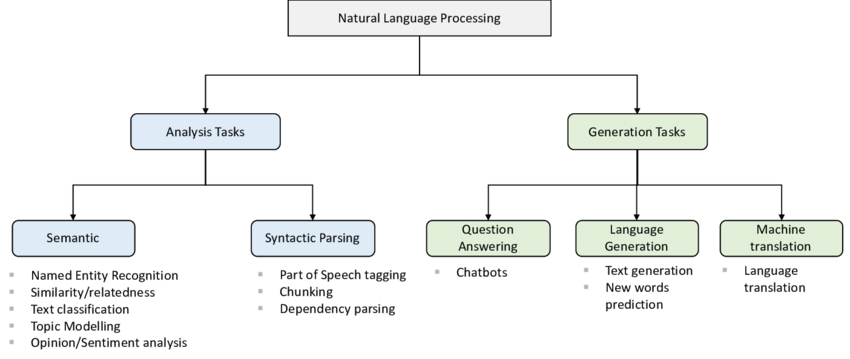
</div>

# `1. Языковые модели` 

Дана последовательность документов $d_1,\dots, d_N$.

Каждый документ содержит слова $w_1, \dots, w_{L_{d}}$.

$W$ — словарь всевозможных слов.

1. Необходимо для любого множества слов $(w_1, . . . , w_n)$ оценить вероятность следующего слова в предложении:
$$
p(w|w_1, . . . , w_n)
$$

2. В классической постановке качество оценивается через правдоподобие на тестовой выборке.

* $$\mathcal{L}(D_{test}) = \prod_{d \in D_{test}}\prod_{n=1}^{N_d}p(w_n|w_1, . . . , w_{n-1}) \text{ — правдоподобие}$$

* $$\mathcal{L}(D_{test}) = \prod_{d \in D_{test}} \left\{\prod_{n=1}^{N_d}p(w_n|w_1, . . . , w_{n-1}) \right\}^{-\cfrac{1}{N_d}} \text{ — перплексия}$$

**Примечание:** В качестве объектов $w_1, \dots, w_{L_{d}}$ можно рассматривать и слова. Однако сегодня мы будем разбирать только случаи слов. 

**Примечание:** Что неожиданно, всё не кончается словами и символами. На следующем семинаре вы также узнаете о BPE.

### `Приложения`

1. Исправление опечаток и грамматических ошибок:

$$
p(\text{'м', 'а', 'ш', 'и', 'н', 'а'}) \gg p(\text{'м', 'а', 'ш', 'ы', 'н', 'а'})
$$

2. Машинный перевод.

3. Улучшение других моделей за счёт моделирования распределения слов.

## `1.1 Классические подходы в языковых моделях `

### `N-граммные модели`

$$
p(d) = \prod_{n=1}^{N_d}p(w_n| w_{n-1}, \dots, w_{1}) = p(w_1, w_2,\dots, w_N) \prod_{n=N+1}^{N_d}p(w_n | w_{n-1}, \dots, w_{1}) \approx p(w_1, w_2,\dots, w_N) \prod_{n=N+1}^{N_d}p(w_n|w_{n-1}, \dots, w_{n-N})
$$

Параметры оцениваются частотно по всем N-граммам в корпусе документов.

$$
p(w|w_1, . . . , w_k ) = \cfrac{C(w_1, . . . , w_k , w)}{C(w_1, . . . , w_k )}
$$

#### Проблемы с реализацией:

1. Проблема оценки первого слова в предложении.
2. Проблема **Out-of-vocabulary** слов. Если слово w не встречалось в словаре, любая условная вероятность, содержащая в посылке w, будет равна 0.
3. Чем больше N тем лучше учитываем контекст, но тем больше нулевых вероятностей.
4. Сколько существует N-грамм от $K$ слов? По-хорошему $K^N$. Уже в самых простых задачах $K = 10^4 \implies$ модель невозможно хранить для $N>4$.

#### Биграммная модель (N=2) на примере:


Предложение, для которого хотим оценить вероятность:
$d = (\text{Я}, \text{пошёл}, \text{в}, \text{магазин})$
Можно так:

$$p(d) = p(\text{магазин}|\text{в})p(\text{в}|\text{пошёл})p(\text{пошёл}|\text{Я})p(\text{Я})$$

Но лучше так:

$$p(d) = p(\text{магазин}|\text{в})p(\text{в}|\text{пошёл})p(\text{пошёл}|\text{Я})p(\text{Я}|\text{<start>})$$

Добавляем в начало каждого предложения токен \<start\>, чтобы лучше моделировать вероятности первых слов.

В общем случае 
$$
p(d) = p(w_1|\text{<start>}) \prod_{n=2}^{N_d}p(w_n|w_{n-1})
$$

#### Некоторые улучшения:

Проблема №2 значительно ухудшает модель, так как вся цепочка вероятности в данном случае обнуляется.

* Исправление нормировкой:
$$ p(w|w_1, \dots , w_n ) = \cfrac{C(w_1, \dots , w_n, w) + \alpha}{C(w_1, \dots , w_n) + α|W | }\text{, где } \alpha \text{ — мало}
$$

* Katz backoff:
Основная идея: если не встречали $(k+1)$-грамму, но встречали $k$-грамму, то можем произвести 'откат'

$$
C(w_{n-k}, \dots , w_n, w) = 
     \begin{cases}
       C(w_{n-k}, \dots , w_n, w) \beta(w_{n-k}, \dots , w_n) &\quad \text{если}\quad C(w_{n-k}, \dots , w_n) > 0\\
       C(w_{n-k+1}, \dots , w_n, w)\alpha(w_{n-k}, \dots , w_n)  &\quad\text{иначе} 
     \end{cases}
$$

Формула может раскрываться рекурсивно. Параметры $\alpha, \, \beta$ определяются из условия нормировки.

#### Очевидные недостатки:

Рассмотрим простой пример: $d = (\text{Я}, \text{погладил}, \text{кота}, \text{нет}, \text{денег},\text{попросили})$

$$
  p(d) = p(\text{попросили}|\text{денег})p(\text{денег}|\text{нет})p(\text{нет}|\text{кота})p(\text{кота}|\text{погладил})p(\text{погладил}|\text{Я})p(\text{Я}|\text{<start>})
$$

Предложение целиком не имеет смысла, но каждая последовательная Би-грамма имеет высокую вероятность.

## `1.2 Языковые модели на основе RNN`

Допустим нам даны некоторые непрерывные представления слов (эмбеддинги). Языковая модель на основе LSTM строится как:

$$p(\tilde{w}_{t+1}|w_{t}, . . . , w_{t-k}) = \text{Softmax}(Uh_{t+1} + b)\text{, где }\\ (h_{t+1}
, C_{t+1} )= \text{LSTM}(h_{t}, C_{t}, e_t) \\
e_t = \text{Embedding}(w_t)$$

<div>
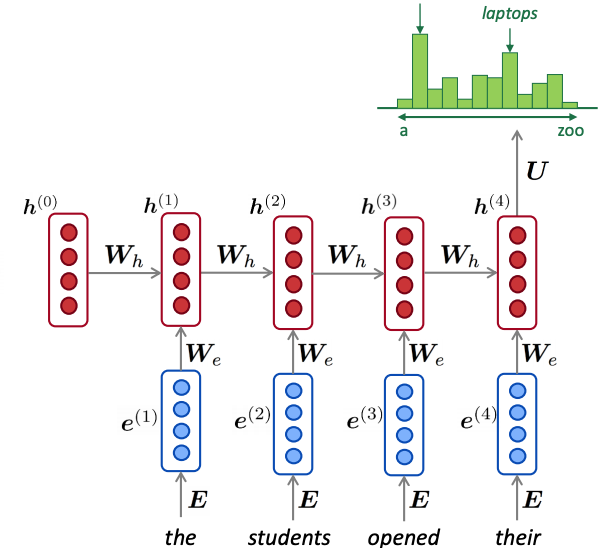
</div>

Для оптимизации обучения будем пытаться предсказать новое слово в каждый момент времени.

Функция потерь в таком случае вычисляется в каждый момент времени.

$$
\mathcal{L} = \sum_{t=1}^T \mathcal{L}_t \\
\mathcal{L}_t= − \sum_{w \in W}[w = w_t] \log p(w = w_t|w_{t-1}, . . . ,w_{t−k})
$$

<div>
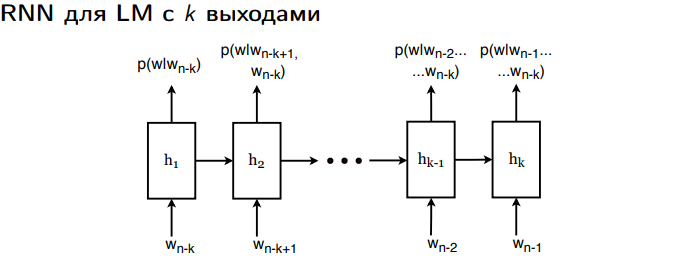
</div>

#### Проблемы реализации LM на основе RNN

Проблемы 1, 3 и 4 более нас не тревожат:

* В качестве первого слова всегда берём спец. символ \<SOS\> 

* Вероятность зависит от контекста (определяемого LSTM) и не будет из непрерывности 0 при отсутствии аналогичных фраз на обучении.

* В качестве модели достаточно хранить LSTM и представления слов.

Осталась проблема Out-of-vocabulary слов, которые могут появиться во время инференса.

Для её решения существует 3 подхода:

1. Использование `<UNK>` токена. При обучении на него можно заменить редкие слова.
2. Использование посимвольных моделей. 
3. Использование посимвольной модели для каждого нового слова.

## `1.3 Применение в задачах обучения с учителем` 

Задача языкового моделирования является задачей обучения без учителя. Поэтому данный метод может применяться для улучшения качества в задачах с неполной разметкой. 

Кроме решения базовой задачи могут использоваться для:

1. Transfer learning.

2. Регуляризации моделей.

3. Multitask learning.

# `2. Эмбеддинги — векторные представления слов`

В базовом курсе машинного обучения для кодирования слов использовалась модель One-Hot-Encoding. Для случаев нейронных сетей она не подходит из-за недопустимо большой размерности.

Например, если в небольшой задаче размер корпуса ( число слов ) равно $10.000$, то первый слой в модели будет иметь размер $10.000 \times 100$. Что для решения небольшой задачи уже недопустимо много.

<div>
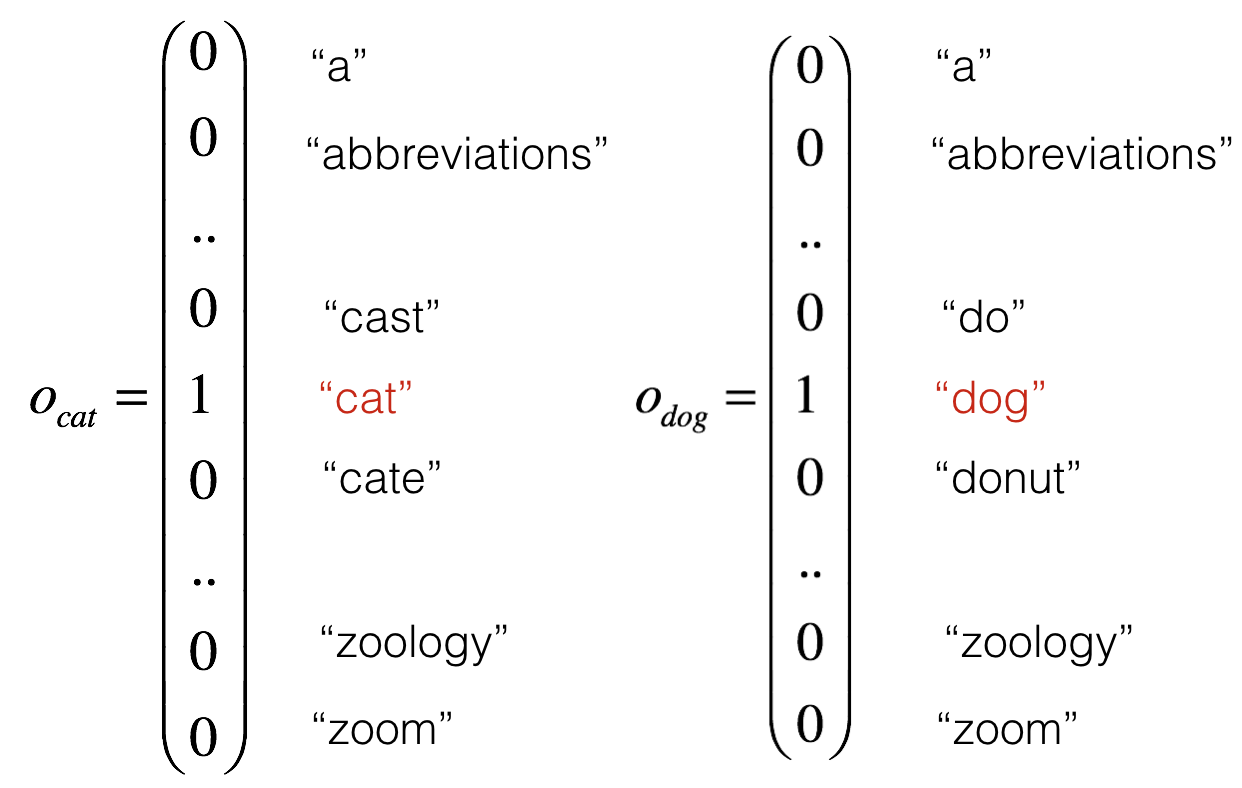
</div>

Поэтому на практике используется другой подход, который мы сейчас обсудим.



## `Общая задача построения эмбеддингов:`

Дано: $D = \{w_1, w_2, . . . , w_{N_d}\}_{d=1}^{d=N}$ — текстовая коллекция, $w_i \in W$ — словарь коллекции

Найти: векторное представление $v_w ∈ R^m$ для каждого слова $w \text{, где } m << |W|$

При этом хорошие представления будут иметь:

1. Соответствие близости по смыслу слов к близости по расстоянию между векторами.
2. Интерпретируемостью арифметических операции над словами в пространстве эмбеддингов.
3. Хорошее качество при решении конечной задачи.


Задачи связанные с построенными векторами:

1. Поиск близких слов, синонимов и т.п.
2. Получение представление документа, которое будет использоваться в других задачах машинного обучения.
3. Использование в качестве фиксированного представления в сложной архитектуре (например, рекуррентной сети)
4. Использование для инициализации представлений в сложной архитектуре (снова RNN)

**Все эти аспекты рассмотрим на практике**

### `Подход №1: Count-based`

Пусть $n_{u,v}$ — количество документов, в которых два слова $u,v$ встречались вместе.

$U, V$ — матрица представлений и доп представлений. Обе из $\mathbf{R}^{|W|\times m}$ 

<div>
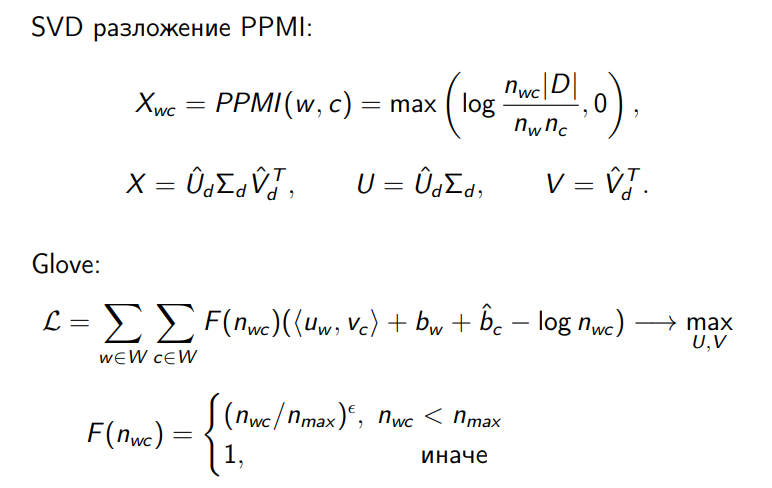
</div>


[Glove](https://nlp.stanford.edu/pubs/glove.pdf)

### `Подход №2: Word2Vec`

Переобозначим: 

$V, U$ — матрица представлений и доп представлений. Обе из $\mathbf{R}^{|W|\times m}$ 

$w_{n}^{N} = (w_n, w_{n-1}, \dots, w_N)^T$

Рассмотрим две наиболее популярные модели данного типа.

<div>
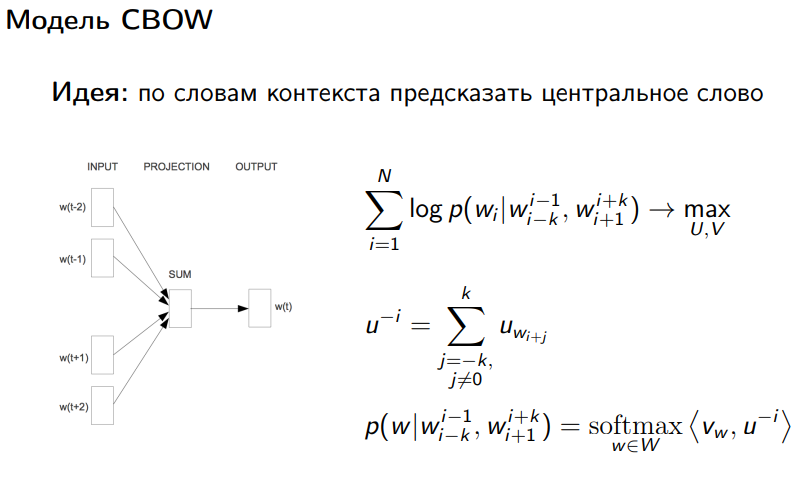
</div>

<div>
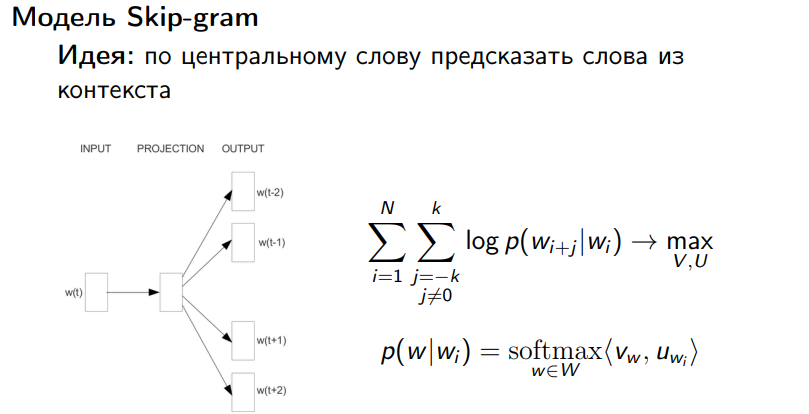
</div>

* skip-gram намного лучше моделирует редкие слова.

* На практике намного медленнее CBOW

* Удачное расширение skip-gram — модель FastText. К ней вернёмся ещё несколько раз.

<div>
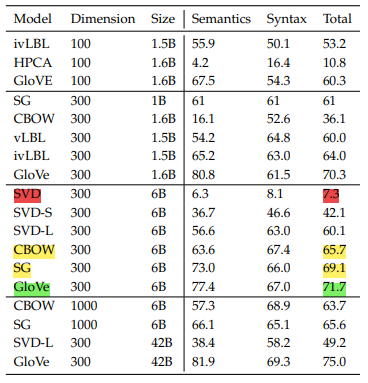
</div>

[Источник таблички](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1224/readings/cs224n-2019-notes02-wordvecs2.pdf)

**На самом деле OHE сводится к эмбеддингам:** После обучения модели, первый линейный слой размера $|W|\times m$ можно будет рассматривать как эмбеддинги слов.

# `3. TorchText`

1. Работа с словарями в TorchText. Отображение символов в токены.

[TORCHTEXT.VOCAB](https://pytorch.org/text/stable/vocab.html)

In [1]:
import os
from functools import partial
from collections import defaultdict
from collections import Counter, OrderedDict

import numpy as np

import torch
import torchtext
from torchtext.vocab import vocab
from torch.utils.data import Dataset, DataLoader

## `3.1. Создание и работа со словарём`

В качестве подхода к построению единого отображения слов в токены в pytorch используется  словари. 

В конструкторе используются следующие понятия:

* `ordered_dict` – Ordered Dictionary отображающий токены в соответствующие им частоты.

* `min_freq=1` – Слова с меньшей частотой не будут входить в итоговый словарь модели.

* `specials=None` – Список спец. символов. Порядок символов при передаче сохранится в итоговом словаре.

* `special_first=True` – Если `True`, то спец. символы будут в начале итогового словаря.

<div>
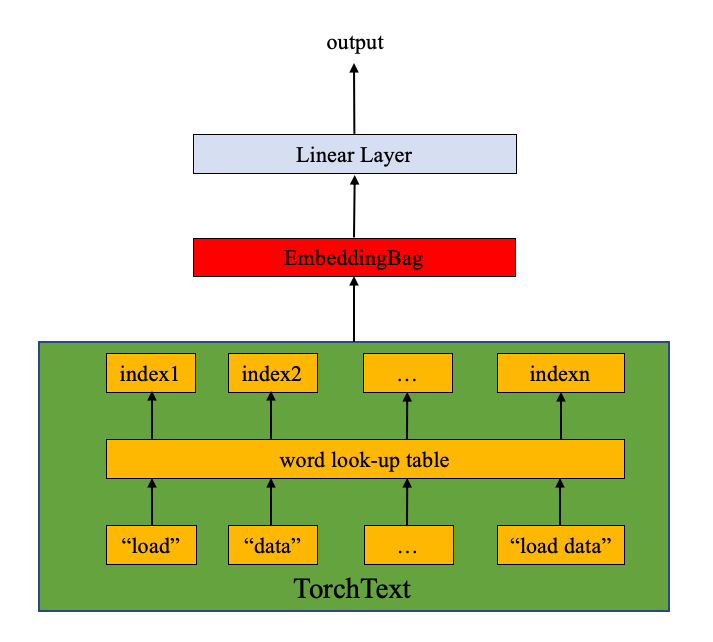
</div>

In [2]:
# Допустим, это наш датасет
data = ['a', 'a', 'b', 'b', 'c', 'e', 'e', 'e', 'f']

# Подсчёт слов — словарь с частотами
counter = Counter(data)
print(counter)

# Упорядоченный словарь
ordered_dict = OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
print(ordered_dict)

Counter({'e': 3, 'a': 2, 'b': 2, 'c': 1, 'f': 1})
OrderedDict([('e', 3), ('a', 2), ('b', 2), ('c', 1), ('f', 1)])


In [3]:
v1 = vocab(ordered_dict, 2, None)
print('Словарь отображающий символы в их токены: ', v1.get_stoi())  
print('Список отображающий токены в их символы: ', v1.get_itos())  

Словарь отображающий символы в их токены:  {'b': 2, 'a': 1, 'e': 0}
Список отображающий токены в их символы:  ['e', 'a', 'b']


In [4]:
# Попробуем получить токен для известного слова
# Два эквивалентных способа
stoi = v1.get_stoi()
stoi['a'], v1['a']

(1, 1)

In [5]:
%timeit stoi['a']

16.7 ns ± 0.343 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [6]:
%timeit v1['a']

219 ns ± 2.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Попробуем подать на вход модели слово, которое в обучающей выборке не встречалось.

In [7]:
print("Входит ли 'а' в словарь?", 'a' in v1)
print("Входит ли 'new' в словарь?", 'new' in v1)
try:
    v1['new']
except:
    print('Token new not found and default index is not set')

Входит ли 'а' в словарь? True
Входит ли 'new' в словарь? False
Token new not found and default index is not set


### `Работа с новыми словами`

In [8]:
unk_token = '<unk>'
v2 = vocab(ordered_dict, 2, ['<unk>'])
print('Словарь отображающий символы в их токены: ', v2.get_stoi())
v2.set_default_index(v2['<unk>'])
print("Входит ли 'а' в словарь?", 'a' in v2)
print("Входит ли 'new' в словарь?", 'new' in v2)
print("Токен слова 'new':", v2['new'])

Словарь отображающий символы в их токены:  {'b': 3, 'a': 2, 'e': 1, '<unk>': 0}
Входит ли 'а' в словарь? True
Входит ли 'new' в словарь? False
Токен слова 'new': 0


In [9]:
v2.append_token('new')
print("Входит ли 'new' в словарь?", 'new' in v2)
print("Входит ли 'newa' в словарь?", 'newa' in v2)

Входит ли 'new' в словарь? True
Входит ли 'newa' в словарь? False


## `3.2 Инициализация датасета`

In [10]:
! pip install ebooklib html2text

Defaulting to user installation because normal site-packages is not writeable


In [11]:
! curl https://cdn.culture.ru/files/c060f3d2-df13-5ea0-96d5-5bba532a27f5/anna-karenina -o anna-karenina.epub

import regex
import html2text
import ebooklib, ebooklib.epub

book = ebooklib.epub.read_epub('anna-karenina.epub')
chapters = list(book.get_items_of_type(ebooklib.ITEM_DOCUMENT))

with open('Anna_Karenina.txt', 'w', encoding='utf-8', errors='ignore') as file:
    for chapter in chapters:
        if 'Text/chapter' in chapter.get_name():
            chapter_text = html2text.html2text(chapter.get_content().decode()).lower()
            processed_text = regex.sub('[\n-]', ' ', chapter_text)
            processed_text = regex.sub('[^а-яё.,:;! ]', '', processed_text)
            processed_text = regex.sub(' +', ' ', processed_text)
            file.write(processed_text)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  853k  100  853k    0     0  3052k      0 --:--:-- --:--:-- --:--:-- 3049k


/home/maksim64/.local/lib/python3.10/site-packages/ebooklib/epub.py:1395: UserWarning: In the future version we will turn default option ignore_ncx to True.
  warnings.warn('In the future version we will turn default option ignore_ncx to True.')


Загрузим том книги 'Анна Каренина'. В качестве набора данных будем иметь строку из примерно $1.5 \cdot 10^6$ символов. Данные были предварительно отчищены, приведены к нижнему регистру и избавлены от лишних символов.

In [12]:
with open ('./Anna_Karenina.txt', 'r') as f:
    data = f.readlines()[0]

data[13:104]

'все счастливые семьи похожи друг на друга, каждая несчастливая семья несчастлива по своему.'

In [13]:
counter = Counter(data)
print('Распределение символов в тексте:', counter)

Распределение символов в тексте: Counter({' ': 270262, 'о': 154081, 'е': 117351, 'а': 111176, 'н': 92650, 'и': 88216, 'т': 80090, 'с': 70531, 'л': 67543, 'в': 62893, 'р': 52643, 'к': 45851, 'д': 39781, ',': 39338, 'м': 38345, 'у': 36460, 'п': 32263, 'я': 29031, 'ь': 26788, 'ы': 24779, 'г': 24306, 'б': 23525, 'ч': 22822, 'з': 21914, '.': 16987, 'ж': 15354, 'й': 13751, 'ш': 11631, 'х': 10236, 'ю': 8417, 'э': 4765, 'щ': 3797, 'ц': 3469, '!': 1545, 'ф': 1346, ';': 1108, ':': 706, 'ъ': 395})


In [14]:
vocabulary = vocab(
    OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True)), 
    min_freq=0, specials=['<pad>', '<unk>']
)
vocabulary.set_default_index(vocabulary['<unk>'])

print("Входит ли английская 'q' в словарь?", 'q' in vocabulary)
print("Токен буквы 'q':", vocabulary['q'])
print("Токен символа ' ':", vocabulary[' '])

vocabulary = vocab(
    OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True)), 
    0, ['<unk>', '<pad>']
)
vocabulary.set_default_index(vocabulary['<unk>'])

print("Входит ли английская 'q' в словарь?", 'q' in vocabulary)
print("Токен буквы 'q':", vocabulary['q'])
print("Токен символа ' ':", vocabulary[' '])

Входит ли английская 'q' в словарь? False
Токен буквы 'q': 1
Токен символа ' ': 2
Входит ли английская 'q' в словарь? False
Токен буквы 'q': 0
Токен символа ' ': 2


Составление датасета типа torch.utils.data.Dataset для загрузки текста.

In [15]:
class BookDataset(Dataset):
    def __init__(self, text_words, vocab, max_len, intersection=0):
        """
        :param List[str] text_words: список слов — слова из выборки (или одна строка из букв)
        :param torchtext.Vocab vocab: словарь, по которому можно отобразить слова (или буквы) в токены
        
        :param int max_len: длина предложения
        
        :param int intersection: длина наложения соседних предложений
        ...    Например дан текст: шла Саша по Шоссе и сосала сушку
        ...    max_len = 3, intersection = 2 :
        ...        шла Саша по, Саша по Шоссе, по Шоссе и, Шоссе и сосала, и сосала сушку
        ...    max_len = 3, intersection = 1:
        ...        шла Саша по, по Шоссе и, и сосала сушку
        ...    max_len = 3, intersection = 0:
        ...        шла Саша по, Шоссе и сосала 
        """
        super().__init__()
        
        self.max_len = max_len
        self.intersection = intersection
        self.num_sections = len(text_words) // (self.max_len - self.intersection)
        self.text = text_words[:(self.max_len - self.intersection) * self.num_sections]
        self.tokens = [vocab[x] for x in text_words]
        
    def __getitem__(self, idx):
        """
        Принимает индекс объекта.
        Возвращает словарь следующего вида:
            {
                'text' str: текст предложения,
                'tokens' dict: 'object': предложение в токенах, кроме последнего слова
                               'target': предложение в токенах, кроме первого слова
            }
        
        """
        token_data = self.tokens[
            idx * (self.max_len - self.intersection): 
            idx * (self.max_len - self.intersection) + self.max_len
        ]
        text_data = self.text[
            idx * (self.max_len - self.intersection): 
            idx * (self.max_len - self.intersection) + self.max_len
        ]
        return {
            'tokens': {
                'object': torch.tensor(token_data[:-1], dtype=torch.long),
                'target': torch.tensor(token_data[1: ], dtype=torch.long)
            },
            'text': text_data[:-1]
        }
    
    def __len__(self):
        """
        Возвращает кол-во объектов в выборке
        
        """
        return self.num_sections

In [16]:
dataset = BookDataset(data, vocabulary, 40, intersection=23)
dataloader = DataLoader(dataset, 10, False)

x = next(iter(dataloader))
print('Объект-текст:', x['text'][1])
print('Кодирование объекта:', x['tokens']['object'][1])
print('Необходимо предсказать:', x['tokens']['target'][1])

Объект-текст: счастливые семьи похожи друг на друга, 
Кодирование объекта: tensor([ 9, 24,  5,  9,  8, 10,  7, 11, 21,  4,  2,  9,  4, 16, 20,  7,  2, 18,
         3, 30,  3, 27,  7,  2, 14, 12, 17, 22,  2,  6,  5,  2, 14, 12, 17, 22,
         5, 15,  2])
Необходимо предсказать: tensor([24,  5,  9,  8, 10,  7, 11, 21,  4,  2,  9,  4, 16, 20,  7,  2, 18,  3,
        30,  3, 27,  7,  2, 14, 12, 17, 22,  2,  6,  5,  2, 14, 12, 17, 22,  5,
        15,  2, 13])


## `3.3 Построение и работа с эмбеддингами в pytorch.`

**Пока будем говорить только о том, как загрузить и достать готовые представления в pytorch**

В Pytorch есть возможность загрузить готовые вектора в класс torchtext.vocab.Vectors.

Далее можно использовать метод get_vecs_by_tokens, чтобы сразу получать эмбеддинги из токенов.

[Здесь можно посмотреть доступные предобученные модели.](https://pytorch.org/text/stable/_modules/torchtext/vocab/vectors.html)

In [17]:
# Загружаем соответствующий словарь с готовыми представлениями.
vec = torchtext.vocab.GloVe(name='6B', dim=50)

In [18]:
words = (
    ['man', 'king', 'woman', 'queen'] + 
    ['Moscow', 'Russia', 'London', 'Britain'] +
    ['Moscow', 'River', 'London', 'thames'] +
    ['Boots', 'legs', 'shirt', 'body']
)
# lower_case_backup — внутри класса приведёт слова к нижнему регистру перед поиском
reprs = vec.get_vecs_by_tokens(words, lower_case_backup=True)

In [19]:
vec_dict = vec.stoi # Остальные методы отсутствуют
popular_words = list(vec_dict.keys())[:10_000]
print('Число слов в словаре:', len(vec_dict.keys()))

Число слов в словаре: 400000


## `3.4 Интерпретация эмбеддингов с использованием косинусной меры сходства`

Для измерения сходства двух слов можно использовать предположение о близости по некоторой метрике их эмбеддингов. 

Рассмотрим косинусную меру сходства
:
$$\text{CosineSimilarity(u, v)} = \frac {u \cdot v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

$\theta$ — угол между векторами $u$ и $v$.

<div>
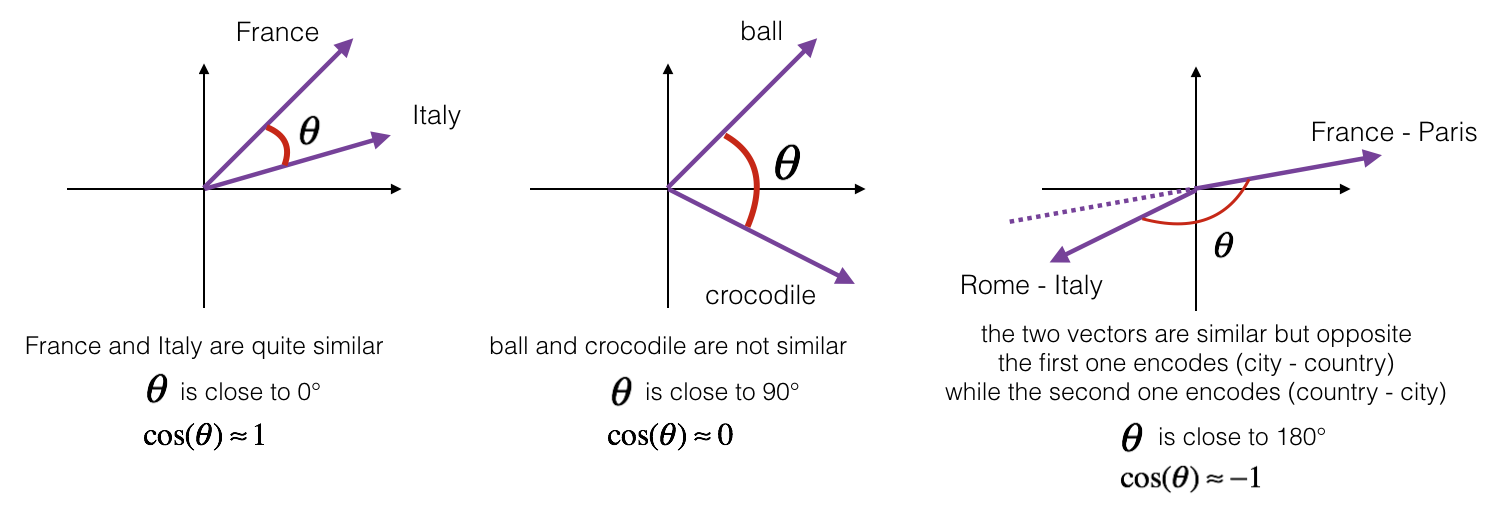
</div>

In [20]:
def cosine_similarity(u, v):
    """
        Вычисление меры сходства cosine между векторами
    """
    dot = torch.dot(u,v)
    norm_u = torch.sqrt(torch.sum(u * u))
    norm_v = torch.sqrt(torch.sum(v * v))
    cosine_similarity = dot / (norm_u * norm_v)
    
    return cosine_similarity

In [21]:
for idx in range(4):
    similarity = cosine_similarity(reprs[0 + 4 * idx] - reprs[1 + 4 * idx], reprs[2 + 4 * idx] - reprs[3 + 4 * idx]).item()
    print(
        '{0} - {1} =? {2} - {3} < --- > similarity: {4:.2f}'.format(
            words[0 + 4 * idx], words[1 + 4 * idx], words[2 + 4 * idx], words[3 + 4 * idx], similarity
        )
    )

man - king =? woman - queen < --- > similarity: 0.84
Moscow - Russia =? London - Britain < --- > similarity: 0.80
Moscow - River =? London - thames < --- > similarity: 0.64
Boots - legs =? shirt - body < --- > similarity: 0.48


In [22]:
def complete_top_10_analogy(words, vocab_with_embeddings, popular_words):
    """
    Проводим аналогию слов вида
    №1 соотносится с №2 так, как №3 c №4, где №4 необходимо предсказать  
    """
    # Получим эмбеддинги слов
    embs = vocab_with_embeddings.get_vecs_by_tokens(words)

    # Худшая из лучших косинусных метрик на данный момент
    min_max_cosine_sim = 0
    # Лучшие на данный момент слова и их метрики
    best_word = {}
    
    # Не допускаем повторения слов
    used_words = set(words)
    
    # Проходим по всем словам из словаря
    for w in popular_words:        
        
        if w in used_words:
            continue

        # Вычисляем меру сходства между векторами 
        cosine_sim = cosine_similarity(embs[1] - embs[0], vocab_with_embeddings.get_vecs_by_tokens([w])[0] - embs[2])
        
        # Процедура обновления топ-10 слов по косинусному сходству
        if np.abs(cosine_sim) > min_max_cosine_sim:
            best_word[w] = cosine_sim
            
            if len(best_word.keys()) > 10:
                
                lowest_index = np.argsort(np.abs(list(best_word.values())))[0]
                del best_word[list(best_word.keys())[lowest_index]]

            min_max_cosine_sim = np.min(np.abs(list(best_word.values())))
            
    return sorted(best_word.items(), key=lambda x: -x[1])

In [23]:
complete_top_10_analogy(['france', 'french', 'italy'], vec, popular_words)

[('italian', tensor(0.9153)),
 ('spanish', tensor(0.6744)),
 ('greek', tensor(0.6412)),
 ('portuguese', tensor(0.6302)),
 ('well-known', tensor(0.6179)),
 ('english', tensor(0.6168)),
 ('renowned', tensor(0.6155)),
 ('filipino', tensor(0.6052)),
 ('famous', tensor(0.6023)),
 ('argentine', tensor(0.5934))]

In [24]:
complete_top_10_analogy(['man', 'woman', 'boy'], vec, popular_words)

[('girl', tensor(0.6695)),
 ('manager', tensor(-0.4855)),
 ('warriors', tensor(-0.4868)),
 ('ball', tensor(-0.4881)),
 ("'", tensor(-0.4883)),
 ('captain', tensor(-0.4926)),
 ('giants', tensor(-0.5013)),
 ('rangers', tensor(-0.5085)),
 ('defensive', tensor(-0.5344)),
 ('boss', tensor(-0.5461))]

**Используем, что для нового неизвестного токена его представление будет нулевым:**

С помощью той же функции можем искать 10 самых схожих объектов с некоторым словом.

Так как 
$$
\text{cosine}(w-\mathbb{0},u-\mathbb{0}) = \text{cosine}(w,u)
$$

In [25]:
unk = ''.join([str(i) for i in np.random.randint(0, 9, 100)])
print('Представление слова \n' , unk, ' : \n', vec.get_vecs_by_tokens([unk])[0])

Представление слова 
 5762152188386731556661368424785205615775610508207310117144201821787134744848733235875542560255507764  : 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


In [26]:
complete_top_10_analogy([unk, 'man', unk], vec, popular_words)

[('woman', tensor(0.8860)),
 ('boy', tensor(0.8564)),
 ('another', tensor(0.8453)),
 ('old', tensor(0.8372)),
 ('one', tensor(0.8276)),
 ('who', tensor(0.8245)),
 ('him', tensor(0.8195)),
 ('turned', tensor(0.8154)),
 ('whose', tensor(0.8120)),
 ('himself', tensor(0.8077))]

In [27]:
complete_top_10_analogy([unk, 'machine', unk], vec, popular_words)

[('machines', tensor(0.8239)),
 ('device', tensor(0.8176)),
 ('using', tensor(0.7790)),
 ('gun', tensor(0.7509)),
 ('used', tensor(0.7493)),
 ('devices', tensor(0.7369)),
 ('uses', tensor(0.7261)),
 ('portable', tensor(0.7247)),
 ('automatic', tensor(0.7220)),
 ('drives', tensor(0.7156))]

In [28]:
# Другая огромная модель
# vec = torchtext.vocab.GloVe(name="twitter.27B", dim="200")

# Одна из самых больших моделей
vec_fast = torchtext.vocab.FastText(language="en")

In [29]:
vec_fast_dict = vec_fast.stoi # Остальные методы отсутствуют
popular_words = list(vec_fast_dict.keys())[:100_000]
print('Число слов в словаре:', len(vec_fast_dict.keys()))

Число слов в словаре: 2519370


Именно для этого подаётся упорядоченный по популярности словарь.

In [30]:
complete_top_10_analogy(['france', 'french', 'italy'], vec_fast, popular_words)

[('italian', tensor(0.7873)),
 ('spanish', tensor(0.5723)),
 ('german', tensor(0.5548)),
 ('portuguese', tensor(0.5439)),
 ('neapolitan', tensor(0.5416)),
 ('english', tensor(0.5353)),
 ('milanese', tensor(0.5182)),
 ('maltese', tensor(0.5180)),
 ('dutch', tensor(0.5177)),
 ('sicilian', tensor(0.5172))]

In [31]:
complete_top_10_analogy(['man', 'woman', 'boy'], vec_fast, popular_words)

[('girl', tensor(0.4454)),
 ('female', tensor(0.4117)),
 ('women', tensor(0.4013)),
 ('feminist', tensor(0.4008)),
 ('womanhood', tensor(0.3905)),
 ('suffragist', tensor(0.3851)),
 ('midwives', tensor(0.3844)),
 ('midwife', tensor(0.3797)),
 ('pregnant', tensor(0.3671)),
 ('childbirth', tensor(0.3666))]

In [32]:
complete_top_10_analogy([unk, 'man', unk], vec_fast, popular_words)

[('woman', tensor(0.6511)),
 ('stranger', tensor(0.5506)),
 ('boy', tensor(0.5457)),
 ('spider', tensor(0.5372)),
 ('girl', tensor(0.5342)),
 ('beggar', tensor(0.5278)),
 ('gentleman', tensor(0.5231)),
 ('thug', tensor(0.5211)),
 ('kraven', tensor(0.5204)),
 ('englishman', tensor(0.5180))]

In [33]:
complete_top_10_analogy([unk, 'machine', unk], vec_fast, popular_words)

# Всё что имеет в себе machine оказалось близким
# Объяснение этому скоро узнаем

[('machines', tensor(0.7856)),
 ('machineguns', tensor(0.6109)),
 ('machinegun', tensor(0.6087)),
 ('submachine', tensor(0.5577)),
 ('gun', tensor(0.5450)),
 ('automaton', tensor(0.5443)),
 ('machined', tensor(0.5357)),
 ('machinery', tensor(0.5321)),
 ('guns', tensor(0.5259)),
 ('autocannon', tensor(0.5105))]

[Таблица](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1224/readings/cs224n-2019-notes02-wordvecs2.pdf) качества моделей обученных на датасетах Wiki2014 + GigaWorld5.

## `3.5 Свои эмбеддинги в pytorch`

Самый простой  и лучший' (в смысле некоторой обучаемой модели, а не семантической интерпретируемости) способ обучить эмбеддинги — инициализировать векторы случайным образом, а затем пропускать по ним градиент. Т.е. рассматривать как обучаемый параметр при прямом проходе сети.

**Инициализация Эмбеддингов: класс `torch.nn.Embedding`**

* `num_embeddings` (int) – размер словаря (количество слов, требующих эмбеддингов). Включает в себя спец. слова. Можно передавать `vocab.__len__`

* `embedding_dim` (int) – размерность изучаемого представления.

* `padding_idx` (int, optional) – если указан, то вектор соответствующий этому токену обучаться не будет, по умолчанию будет равен 0. 

**Важно!** padding_idx используется для обособления начала/конца строки. Векторы других спец символов, например `<unk>`, обучаться будут.

* `max_norm` (float, optional) – максимальная норма векторного представления, если таковая указана.

* `norm_type` (float, optional) – параметр нормы (p-norm).

* `scale_grad_by_freq` (bool, optional) – Если True, то градиенты будут считаться с учётом частоты слова в мини-батче.

* `sparse` (bool, optional) – Если `True`, то градиент по матрице эмбеддингов будет вычисляться в sparse виде. (Нужно, например, если вы захотели дообучить некоторые из приведённых ранее эмбеддингов)

**Важно!** веса можно инициализировать своими готовыми представлениями — разберём на примере.

# `4. Пример решения задачи тэггинга частей предложения`

Задача ['chunking'](https://www.clips.uantwerpen.be/conll2000/chunking/). У каждого слова в предложении есть часть предложения ( подлежащее/сказуемое/дополнение ) и тип (существительное/глагол). Необходимо распознать тип каждого слова, а так же обозначить начало каждой части предложения:

* 'B' — начало части предложения, 'I' — её продолжение
* 'NP' — часть (noun phrase), 'VP' — verbal phrase и т.д.

Рассмотрим пример одного предложения и семантических тэгов:

    He           B-NP
    reckons      B-VP
    the          B-NP
    current      I-NP
    account      I-NP
    deficit      I-NP
    will         B-VP
    narrow       I-VP
    to           B-PP
    only         B-NP
    \#           I-NP
    1.8          I-NP
    billion      I-NP
    in           B-PP
    September    B-NP
 

In [34]:
import torch

import torchvision
from torchvision import transforms

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

/tmp/ipykernel_1370/1701260059.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [ ]:
! mkdir -p ./datasets/CoNLL2000Chunking/
! curl https://www.clips.uantwerpen.be/conll2000/chunking/test.txt.gz -o ./datasets/CoNLL2000Chunking/test.txt.gz
! curl https://www.clips.uantwerpen.be/conll2000/chunking/train.txt.gz -o ./datasets/CoNLL2000Chunking/train.txt.gz

! gzip -d datasets/CoNLL2000Chunking/test.txt.gz --keep -f
! gzip -d datasets/CoNLL2000Chunking/train.txt.gz --keep -f

In [35]:
def read_conll2000(path):
    """
    Подготовка данных из датасета conll
    """

    token_seq = []
    label_seq = []
    
    with open(path, 'r') as file:
        cur_sentence = []
        cur_labels = []
        for line in file.readlines():
            # Вставляем, если не разделитель
            if line == '\n':
                token_seq.append(cur_sentence)
                label_seq.append(cur_labels)
                cur_sentence = []
                cur_labels = []
            else:
                word, _, label = line.split(' ')
                cur_sentence.append(word.lower())
                cur_labels.append(label[:-1])

    return token_seq, label_seq

In [36]:
test_X, test_y = read_conll2000('./datasets/CoNLL2000Chunking/test.txt')
train_X, train_y = read_conll2000('./datasets/CoNLL2000Chunking/train.txt')

print('Длина тестовой выборки:', len(test_X))
print('Длина обучающей выборки:', len(train_X))

Длина тестовой выборки: 2012
Длина обучающей выборки: 8936


In [37]:
print(
    'Средняя длина предложений: {:.1f}'.format(
        sum([len(s) for s in test_X] + [len(s) for s in train_X]) / (len(test_X) + len(train_X))
))
print(
    'Максимальная длина предложений:', 
    max(max([len(s) for s in test_X]), max([len(s) for s in train_X]))
)

Средняя длина предложений: 23.7
Максимальная длина предложений: 78


Используем самый простой способ борьбы с предложениями произвольной длины ( **В общем случае совершенно некорректный!** )

Некорректность процедуры заключается в подсчёте максимальной длины предложения и по тестовой выборке.

На практике так не делается. Используется специальная функция collate_fn, которая делает ту же процедуру, но отдельно для каждого батча. С одной стороны экономия памяти с таким методом в нашем случае вышла бы примерно в 4 раза. С другой, с приходом в тестовой выборке предложения длиннее 78 в модель не нужно было бы вносить изменений.


In [38]:
train_X = [s + ['<pad>'] * (78 - len(s)) for s in train_X]
test_X = [s + ['<pad>'] * (78 - len(s)) for s in test_X]

train_y = [s + ['<pad>'] * (78 - len(s)) for s in train_y]
test_y = [s + ['<pad>'] * (78 - len(s)) for s in test_y]

print(
      'Средняя длина предложений:', 
      sum([len(s) for s in test_X] + [len(s) for s in train_X]) / (len(test_X) + len(train_X))
)
print(
      'Максимальная длина предложений:', 
      max(max([len(s) for s in test_X]), max([len(s) for s in train_X]))
)

Средняя длина предложений: 78.0
Максимальная длина предложений: 78


In [39]:
words_dict = Counter([word for sentence in train_X for word in sentence])
ordered_dict = OrderedDict(words_dict)
print('Всего слов в словаре:', len(ordered_dict.keys()))
print('Слов частоты более 3:', sum([1 if freq > 3 else 0 for freq in ordered_dict.values()]))

voc_words = vocab(ordered_dict, 4, specials=['<unk>', '<pad>'])
voc_words.set_default_index(voc_words(['<unk>'])[0])

train_tokens = [voc_words(sentence) for sentence in train_X]
test_tokens = [voc_words(sentence) for sentence in test_X]

print('Предложение в словах: ')
print(' '.join(train_X[195]))
print('В токенах:')
print(train_tokens[195])

Всего слов в словаре: 17259
Слов частоты более 3: 4973
Предложение в словах: 
share prices closed higher in sydney , taipei , wellington , manila , hong kong and singapore and were lower in seoul . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
В токенах:
[390, 998, 416, 292, 3, 0, 18, 0, 18, 0, 18, 1089, 18, 376, 377, 29, 1090, 29, 523, 921, 3, 0, 32, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [40]:
tags_dict = Counter([tag for sentence in train_y for tag in sentence])
print('Словарь тегов:', tags_dict, '\n')
voc_tag = vocab(OrderedDict(tags_dict), specials=['<unk>', '<pad>'])

# Всё равно нужно реализовать, чтобы не ловить ошибку
voc_tag.set_default_index(voc_tag(['<unk>'])[0])

train_tags = [voc_tag(sentence) for sentence in train_y]
test_tags = [voc_tag(sentence) for sentence in test_y]

print('Предложение в тэгах: \n')
print(' '.join(train_y[195]) + '\n')
print('В индексах тегов: \n')
print(train_tags[195])

Словарь тегов: Counter({'<pad>': 485281, 'I-NP': 63307, 'B-NP': 55081, 'O': 27902, 'B-VP': 21467, 'B-PP': 21281, 'I-VP': 12003, 'B-ADVP': 4227, 'B-SBAR': 2207, 'B-ADJP': 2060, 'I-ADJP': 643, 'B-PRT': 556, 'I-ADVP': 443, 'I-PP': 291, 'I-CONJP': 73, 'I-SBAR': 70, 'B-CONJP': 56, 'B-INTJ': 31, 'B-LST': 10, 'I-INTJ': 9, 'I-UCP': 6, 'I-PRT': 2, 'B-UCP': 2}) 

Предложение в тэгах: 

B-NP I-NP B-VP B-ADVP B-PP B-NP O B-NP O B-NP O B-NP O B-NP I-NP O B-NP O B-VP B-ADJP B-PP B-NP O <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

В индексах тегов: 

[2, 4, 5, 10, 3, 2, 8, 2, 8, 2, 8, 2, 8, 2, 4, 8, 2, 8, 5, 9, 3, 2, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [41]:
from torch.utils.data import TensorDataset

# Так как данные полностью переведены в инты и представляют собой 2 матрицы — 
# можно воспользоваться этим методом
test_dataset = TensorDataset(torch.tensor(test_tokens, dtype=torch.long), torch.tensor(test_tags, dtype=torch.long))
train_dataset = TensorDataset(torch.tensor(train_tokens, dtype=torch.long), torch.tensor(train_tags, dtype=torch.long))

In [42]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)

next(iter(train_loader))

[tensor([[  2,   3,   4,  ...,   1,   1,   1],
         [ 33,  34,   4,  ...,   1,   1,   1],
         [ 50,  51,   0,  ...,   1,   1,   1],
         ...,
         [148, 714, 464,  ...,   1,   1,   1],
         [  4, 140, 717,  ...,   1,   1,   1],
         [ 47,  24, 730,  ...,   1,   1,   1]]),
 tensor([[2, 3, 2,  ..., 1, 1, 1],
         [8, 3, 2,  ..., 1, 1, 1],
         [8, 2, 5,  ..., 1, 1, 1],
         ...,
         [2, 4, 4,  ..., 1, 1, 1],
         [2, 4, 4,  ..., 1, 1, 1],
         [3, 2, 4,  ..., 1, 1, 1]])]

А ещё, в torchtext есть [набор готовых датасетов](https://pytorch.org/text/stable/datasets.html). Например, **CoNLL2000** доступен из коробки:

In [1]:
from torchtext.datasets import CoNLL2000Chunking

ds_pipe = CoNLL2000Chunking(root='./', split='train')
# Для датасетов в torchtext используется экспериментальный DataPipe интерфейс:
next(iter(ds_pipe))

[['Confidence',
  'in',
  'the',
  'pound',
  'is',
  'widely',
  'expected',
  'to',
  'take',
  'another',
  'sharp',
  'dive',
  'if',
  'trade',
  'figures',
  'for',
  'September',
  ',',
  'due',
  'for',
  'release',
  'tomorrow',
  ',',
  'fail',
  'to',
  'show',
  'a',
  'substantial',
  'improvement',
  'from',
  'July',
  'and',
  'August',
  "'s",
  'near-record',
  'deficits',
  '.'],
 ['NN',
  'IN',
  'DT',
  'NN',
  'VBZ',
  'RB',
  'VBN',
  'TO',
  'VB',
  'DT',
  'JJ',
  'NN',
  'IN',
  'NN',
  'NNS',
  'IN',
  'NNP',
  ',',
  'JJ',
  'IN',
  'NN',
  'NN',
  ',',
  'VB',
  'TO',
  'VB',
  'DT',
  'JJ',
  'NN',
  'IN',
  'NNP',
  'CC',
  'NNP',
  'POS',
  'JJ',
  'NNS',
  '.'],
 ['B-NP',
  'B-PP',
  'B-NP',
  'I-NP',
  'B-VP',
  'I-VP',
  'I-VP',
  'I-VP',
  'I-VP',
  'B-NP',
  'I-NP',
  'I-NP',
  'B-SBAR',
  'B-NP',
  'I-NP',
  'B-PP',
  'B-NP',
  'O',
  'B-ADJP',
  'B-PP',
  'B-NP',
  'B-NP',
  'O',
  'B-VP',
  'I-VP',
  'I-VP',
  'B-NP',
  'I-NP',
  'I-NP',
  'B-PP'

## `Самая простая модель тэггинга с эмбеддингами.`

<div> 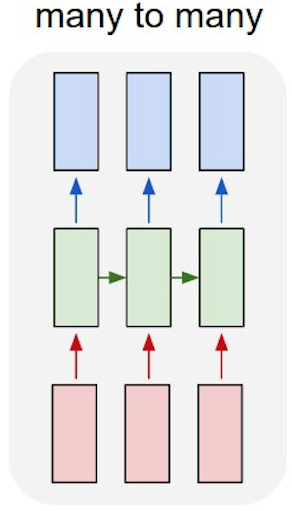
</div>

In [43]:
class SimpleClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab, LSTM_SCHEME,
        pretrained_emb=None 
    ):
        """
        embedding_dim — размер представлений
        hidden_dim — размер скрытого представления
        output_size — количество классов
        vocab — отображение из слов в токены (нужно для оценки кол-ва слов)
        LSTM_SCHEME — функция от embedding_dim, hidden_dim, возвращающая модель RNN
        
        pretrained_emb = (weights, train_flag)
            weights — веса для новых эмбедднигов
            train_flag — если False, то эмбеддинги не обучаются
        """
        super().__init__()

        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size # Количество различных тэгов
        self.embedding_dim = embedding_dim 

        self.embeddings = torch.nn.Embedding(
            num_embeddings=len(vocab),
            embedding_dim=embedding_dim,
            padding_idx=vocab.get_stoi()['<pad>'], # Не обучаем embedding padding'а
        )
        if pretrained_emb is not None:
            weights, train_flag = pretrained_emb
            self.embeddings.load_state_dict({'weight': weights})
            self.embeddings.weight.requires_grad = train_flag

        # Парадигма Batch-First !
        self.rnn = LSTM_SCHEME(embedding_dim, hidden_dim) 
        
        self.tagger = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_dim, self.output_size*2), torch.nn.LeakyReLU(),
            torch.nn.Linear(self.output_size*2, self.output_size))
        self.output = None
    
    def forward(self, tokens):
        """
        tokens: Батч размера (N x L) с токенами слов .

        return: Векторное представление для токена в каждом
        """
        # tokens размера (N x L)

        x = self.embeddings(tokens) # размера (N x L x E)
        x = self.rnn(x)[0] # Парадигма Batch-First (N x L x H)
        
        # Теперь для каждого батча и для каждого момента времени предсказываем тэг

        x = self.tagger(x) # размера (N x L x O)
    
        return x

In [44]:
# Код обучения и вывода экспериментов
def evaluate_torch(model, device, data_loader, loss_fn, acc_fn):
    """
    Возвращает качество и лосс модели на выборке
    Данные из dataloader приходят в tuple (data, target)
    """
    model.eval()
    mean_loss = 0
    mean_acc = 0
    length = 0
    
    with torch.no_grad():
        for _, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.reshape(-1).to(device)
            output = model(data)
            
            # Обновляем качество
            mean_loss += loss_fn(output.reshape(-1, output.shape[-1]), target).item()
            pred = output.argmax(dim=2)
            # Считаем среднее accuracy
            mean_acc += acc_fn(pred, target).cpu() 
            length += 1

    return mean_loss / length, mean_acc / length


def train_torch(
    model, device, train_loader, test_loader, n_epoch, 
    optimizer, scheduler, loss_fn, acc_fn
):
    """
    Обучение и оценивание качества на тесте одновременно
    Данные из dataloader приходят в tuple (data, target)
    """
    train_history, test_history = {'loss':[], 'acc':[]}, {'loss':[], 'acc':[]}
    
    for _ in range(1, n_epoch + 1):
        model.train()
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.reshape(-1).to(device)
            
            # Делаем шаг по батчу
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output.reshape(-1, output.shape[-1]), target)
            loss.backward()

            optimizer.step()
          
        scheduler.step()
        # Добавляем информацию
        loss, acc = evaluate_torch(model, device, train_loader, loss_fn, acc_fn)
        train_history['loss'].append(loss), train_history['acc'].append(acc)
        loss, acc = evaluate_torch(model, device, test_loader, loss_fn, acc_fn)
        test_history['loss'].append(loss), test_history['acc'].append(acc)
        
    return train_history, test_history

def get_exps(model, title, n_epochs=20):
    """
    Эксперименты по обучению моделей для задачи chunll2000
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

    x, y, z = (
        sum(p.numel() for p in model.embeddings.parameters()), 
        sum(p.numel() for p in model.rnn.parameters()), 
        sum(p.numel() for p in model.tagger.parameters())
    )
    print(f'В модели: {x} + {y} + {z} параметров')
  
    train_history, test_history = train_torch(
        model, device, train_loader, test_loader, n_epochs, 
        optimizer, scheduler, loss, acc
    )
    
    # Строим графики loss, acccuracy
    x = np.arange(1, n_epochs + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    
    axes[0].plot(x, train_history['loss'])
    axes[0].plot(x, test_history['loss'])
    
    axes[1].plot(x, train_history['acc'][:])
    axes[1].plot(x, test_history['acc'][:])
    
    axes[0].set_xlabel('Эпоха', fontsize=14)
    axes[1].set_xlabel('Эпоха', fontsize=14)

    axes[0].set_ylabel('Loss', fontsize=14)
    axes[1].set_ylabel('Accuracy', fontsize=14)
    
    axes[0].legend(['Train', 'Test'], prop=dict(size=14))
    axes[1].legend(['Train', 'Test'], prop=dict(size=14))
    
    axes[0].grid(True)
    axes[1].grid(True)
    
    fig.suptitle(title, fontsize=14)
    plt.show()
    
    return train_history, test_history

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [45]:
def padded_acc(output, target):
    """
    При подсчёте accuracy важно не учитывать неинформативные члены
    """
    mask = target != voc_tag['<pad>']
    correct = (output.flatten() == target) * mask
    return correct.sum() / mask.sum()

loss = torch.nn.CrossEntropyLoss(ignore_index=voc_tag['<pad>'], reduction='mean')
acc = padded_acc

## `Языковые модели на основе LSTM`

В модели: 248700 + 60800 + 6024 параметров


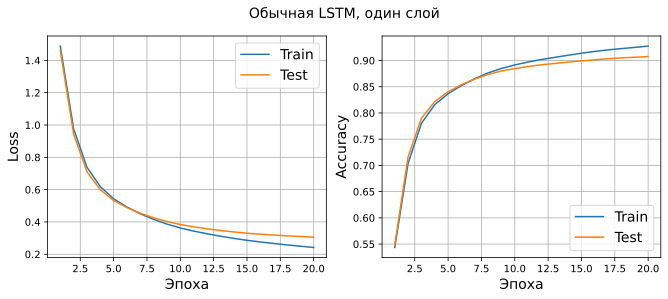

In [46]:
LSTM_SCHEME = lambda E, H: torch.nn.LSTM(E, H, batch_first=True)
model_1 = SimpleClassifier(50, 100, len(voc_tag), voc_words, LSTM_SCHEME).to(device)

_, res_simple = get_exps(model_1, 'Обычная LSTM, один слой')

В модели: 248700 + 40800 + 6024 параметров


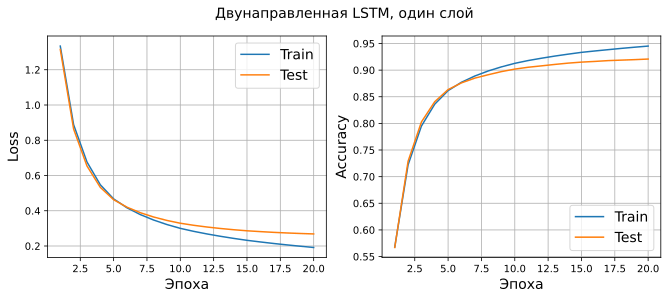

In [47]:
LSTM_SCHEME = lambda E, H: torch.nn.LSTM(E, H // 2, batch_first=True, bidirectional=True)
model_2 = SimpleClassifier(50, 100, len(voc_tag), voc_words, LSTM_SCHEME).to(device)

_, res_bi = get_exps(model_2, 'Двунаправленная LSTM, один слой')

В модели: 248700 + 223200 + 6024 параметров


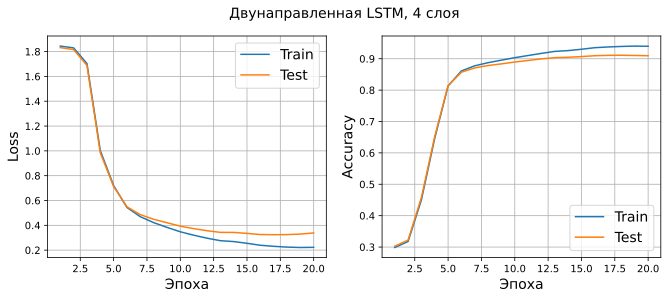

In [48]:
LSTM_SCHEME = lambda E, H: torch.nn.LSTM(E, H // 2, batch_first=True, num_layers=4, bidirectional=True)
model_3 = SimpleClassifier(50, 100, len(voc_tag), voc_words, LSTM_SCHEME).to(device)

_, res_bi_stacked = get_exps(model_3, 'Двунаправленная LSTM, 4 слоя')

Попробуем применить более топологически сложную модель. 

Иллюстрация первого слоя

<div>
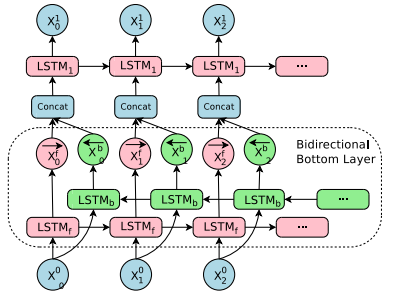

Иллюстрация последующих слоёв: противопоставление обычной модели и skip-sum

<div>
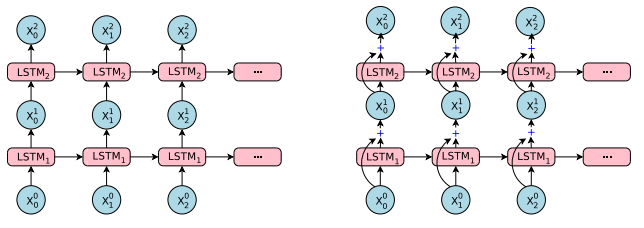
</div>

In [49]:
class Bi_Stacked_sum_LSTM_Layer(torch.nn.Module):
    """
    Глубокая LSTM, первая ячейка двунаправленная
    
    Дополнительно используется skip-connect между каждым блоком ( тип — суммирование )
    
    Формат входа как в Batch first LSTM в pytorch — (N, L, M)

    В основу взят только прямой проход LSTM
    """
    def __init__(self, input_size, hidden_size, D):
        """
        :param int output_size: число классов
        :param int D: глубина сети, т.е. кол-во LSTM моделей поверх друг друга
        """
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.D = D
        
        f = lambda input_size, hidden_size: torch.nn.LSTM(input_size, hidden_size, bidirectional=False, batch_first=True)
        
        # Список всех внутренних блоков
        self.first_LSTM_fwd = f(input_size, hidden_size)
        self.first_LSTM_bwd = f(input_size, hidden_size)
        # Первый блок принимает на вход конкатенацию 2 LSTM, поэтому удвоенный вход
        self.hidden_LSTM = torch.nn.ParameterList(
            [f(2 * hidden_size, hidden_size)] + 
            [f(hidden_size, hidden_size)] * (self.D - 2)
        )
        
    def forward(self, X):
        """
        Решается в два этапа:
            1. Первый проход: получаем два выхода из LSTM в разном направлении
               конкатенируем эти выходы
            2. Для каждой внутренней сетки делаем проброс выхода вперёд (residual-sum)
        """
        #  X размера N x L x M
        batch_size, L, M = X.shape
        
        # 1. Получим выходы двунаправленной:
        forward_h, _ = self.first_LSTM_fwd(X)
        
        # Перед подачей в LSTM с обратным направлением нужно обратить X по времени
        backward_h, _ = self.first_LSTM_bwd(torch.flip(X, dims=(1, )))
        
        # Теперь обратить сам выход, чтобы первому моменту времени
        # соответствовал выход от первого момента времени
        backward_h = torch.flip(backward_h, dims=(1, ))
        
        X = torch.cat((forward_h, backward_h), dim=2)
        
        # Применяем остальные сети
        for n, layer in enumerate(self.hidden_LSTM):

            # Получаем только состояния h_t
            output, _ = layer(X)
            if n != 0:
                # Для всех слоёв кроме первого делаем residual связь
                # Т.е. прибавляем к выходу вход X
                output = output + X

            X = output 

        # По - хорошему нужно вернуть h_t, (h_t, c_t)
        return (output,) 

В модели: 248700 + 167440 + 4584 параметров


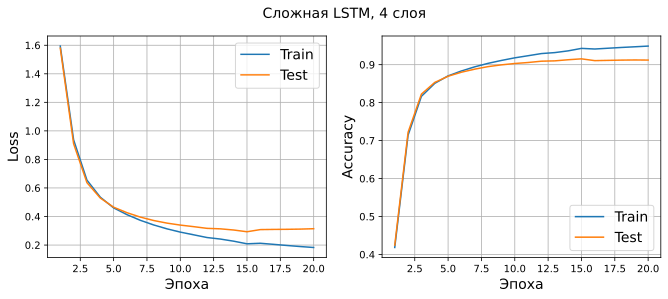

In [50]:
LSTM_SCHEME = lambda E, H: Bi_Stacked_sum_LSTM_Layer(E, H, D=3)

model_4 = SimpleClassifier(50, 70, len(voc_tag), voc_words, LSTM_SCHEME).to(device)

_, res_complex = get_exps(model_4, 'Сложная LSTM, 4 слоя')

## `Используем предобученные эмбеддинги `

In [51]:
# Загружаем соответствующий словарь с готовыми представлениями.
glove = torchtext.vocab.GloVe(name='6B', dim=50)

In [52]:
W, E = len(voc_words), 50
weights_matrix = torch.zeros((W, E))

for idx, word in enumerate(voc_words.get_stoi().keys()):
    try: 
        weights_matrix[idx] = glove[word]
    except KeyError:
        print(f"Нет слова '{word}'")
        weights_matrix[idx] = torch.normal(size=(E, ))

В модели: 248700 + 40800 + 6024 параметров


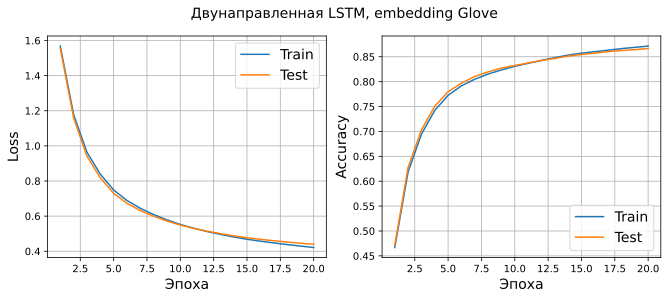

In [53]:
LSTM_SCHEME = lambda E, H: torch.nn.LSTM(E, H // 2, batch_first=True, bidirectional=True)
model_2_pret = SimpleClassifier(
    50, 100, len(voc_tag), voc_words, 
    LSTM_SCHEME, pretrained_emb=(weights_matrix, False)
).to(device)

_, res_pret = get_exps(model_2_pret, 'Двунаправленная LSTM, embedding Glove')

**Почему Glove-embedding показал плохое качество ?**

В модели: 248700 + 40800 + 6024 параметров


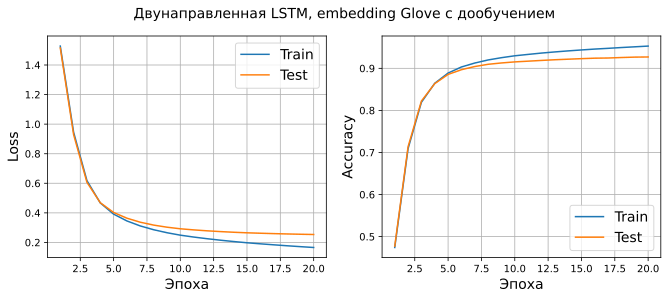

In [54]:
LSTM_SCHEME = lambda E, H: torch.nn.LSTM(E, H // 2, batch_first=True, bidirectional=True)
model_2_semi_pret = SimpleClassifier(
    50, 100, len(voc_tag), voc_words, 
    LSTM_SCHEME, pretrained_emb=(weights_matrix, True)
).to(device)

_, res_semi_pret = get_exps(model_2_semi_pret, 'Двунаправленная LSTM, embedding Glove с дообучением')

**Почему более глубоко не исследуем зависимость от параметров сети?**

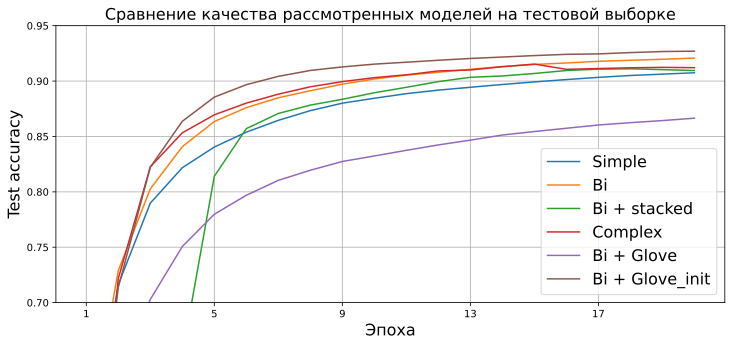

In [55]:
x = np.arange(1, 21)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.plot(x, res_simple['acc']), ax.plot(x, res_bi['acc']), ax.plot(x, res_bi_stacked['acc'])
ax.plot(x, res_complex['acc']), ax.plot(x, res_pret['acc']), ax.plot(x, res_semi_pret['acc'])

ax.set_xlabel('Эпоха', fontsize=16)
ax.set_ylabel('Test accuracy', fontsize=16)

ax.set_xticks(np.arange(1, 21, 4))
ax.set_ylim(0.7, 0.95)
ax.grid(True)

ax.set_title('Сравнение качества рассмотренных моделей на тестовой выборке', fontdict=dict(fontsize=16))
ax.legend(['Simple', 'Bi','Bi + stacked', 'Complex', 'Bi + Glove', 'Bi + Glove_init'], prop=dict(size=16))

plt.show()

Что заметно, наилучшее итоговое качество и скорость сходимости показала простая двунаправленная сеть с инициализацией эмбеддингов из Glove.

# `5 Тонкости задачи генерации текстов`

## `5.1 Генерация текста обученной LM`

Генерация текста в языковых моделях ( не только основанных на RNN ) ( и не только в языковых моделях ) в общем случае проводится по алгоритму использующему вероятностное распределение $p(w|w_1,\dots,w_t)$, обучаемое в модели.

### `Начало и завершение генерации:`

Постановки задачи генерации можно разделить по началу генерации текста:

1. Продолжение предложения: дан кусок текста, необходимо продолжить его.

2. Генерация нового предложения: необходимо с создать предложение с нуля. (символа \<SOS\>)

3. Генерация исходя из внешних данных: начальное состояние задаётся некоторой информацией, например представлением картинки в задаче описания изображения. 

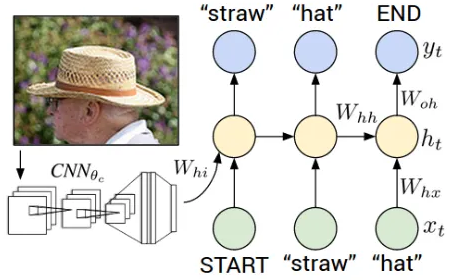
</div>

По завершению процедуры генерации:
1. Ограничение на длину предложения.

2. Бесконечная генерация, оканчивающаяся при наиболее вероятном символе \<EOS\>.

<div>
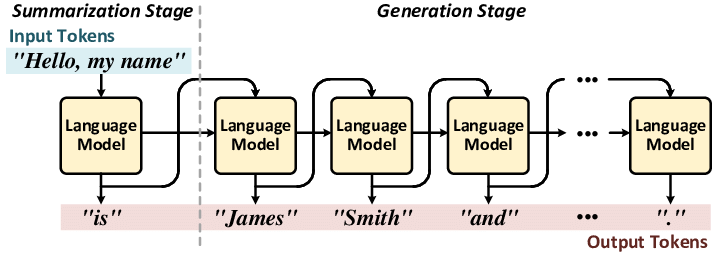
</div>

### `Популярные методы генерации:`

Допустим в момент t даны слова $(w_1, \dots, w_t)$, необходимо сгенерировать ещё $k$ слов:

#### 1. Жадный метод. На каждом шаге от 1 до k генерируем наиболее правдоподобное слово на данный момент.

В вероятностном виде:

$$
p(w_{t+k}, w_{t+k-1}, \dots, w_{t+1}|w_1, \dots, w_t) \approx
p(w_{t+k}| w_1, \dots, w_t, w_{t+1}, \dots , w_{t+k-1}) p(w_{t+k-1}| w_1, \dots, w_t, w_{t+1}, \dots , w_{t+k-2}) \dots
p(w_{t+1}| w_1, \dots, w_t)
$$

Алгоритмически:

$$
w_{t+1} = \text{argmax}p(w_{t+1}| w_1, \dots, w_t) \\
w_{t+j} = \text{argmax}p(w_{t+j}| w_1, \dots, w_{t+j-1})
$$

#### 2. Beam-search.

На первом шаге: выбираем k наиболее вероятных слов.

До остановки:

1. Рассматриваем текущие вероятные последовательности $W_j = (w_1^j,\dots, w_t^j)$ - всего k штук.
$$
W = 
\begin{bmatrix}
    w_1^1      & w_2^1 &  \dots & w_t^1 \\
    w_1^2      & w_2^2 &  \dots & w_t^2 \\
    \dots  & \dots &  \dots & \dots\\
    w_1^k      & w_2^k &  \dots & w_t^k
\end{bmatrix}
$$

2. Пытаемся продолжить её t-ым словом для каждой последовательности:

$$
\hat{W}_i = 
\begin{bmatrix}
    w_1^i      & w_2^i &  \dots & w_t^i & \hat{w}_{t+1}^{i_1}\\
    w_1^i      & w_2^i &  \dots & w_t^i & \hat{w}_{t+1}^{i_2}\\
    \dots  & \dots &  \dots & \dots   & \dots \\
    w_1^i      & w_2^i &  \dots & w_t^i & \hat{w}_{t+1}^{i_k}
\end{bmatrix}
$$

и получаем вероятности
$$
\begin{bmatrix}
    p(\hat{W}_{1,1})      & p(\hat{W}_{1,2}) &  \dots & p(\hat{W}_{1,k}) \\
    p(\hat{W}_{2,1})      & p(\hat{W}_{2,2}) &  \dots & p(\hat{W}_{2,k}) \\
    \dots  & \dots &  \dots & \dots   \\
    p(\hat{W}_{2,1})      & p(\hat{W}_{2,2}) &  \dots & p(\hat{W}_{k,k})
\end{bmatrix}
$$

3. Выбираем соответствующие k наиболее вероятных последовательностей из $k \times k$ штук.

<table><tr>
<td> 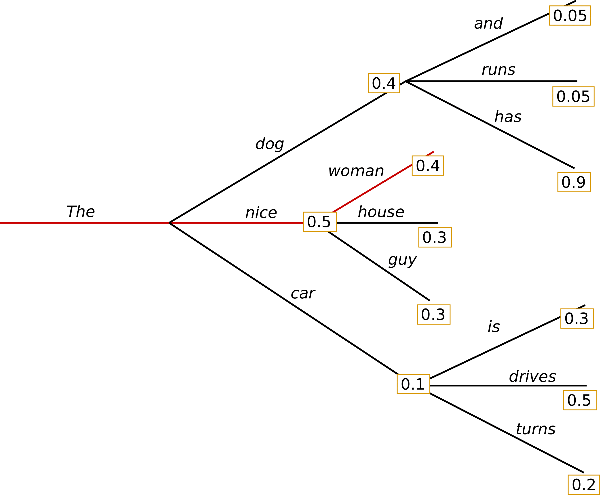 </td>
<td> 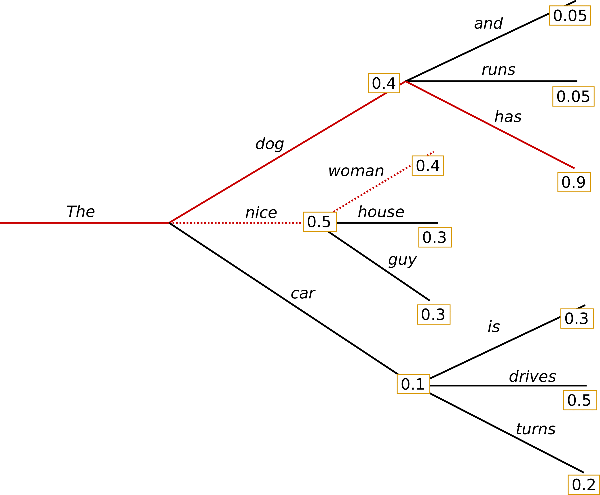 </td>
</tr></table>

#### 3. top-k. Фиксируем $k$ самых вероятных слов и семплируем пропорционально их вероятностям.

#### 4. top-p (nucleus). Фиксируем такое $k$ самых вероятных слов, что их суммарная вероятность более $p$.

Методы отличаются только способом отбора слов-кандидатов $V$

<table><tr>
<td> 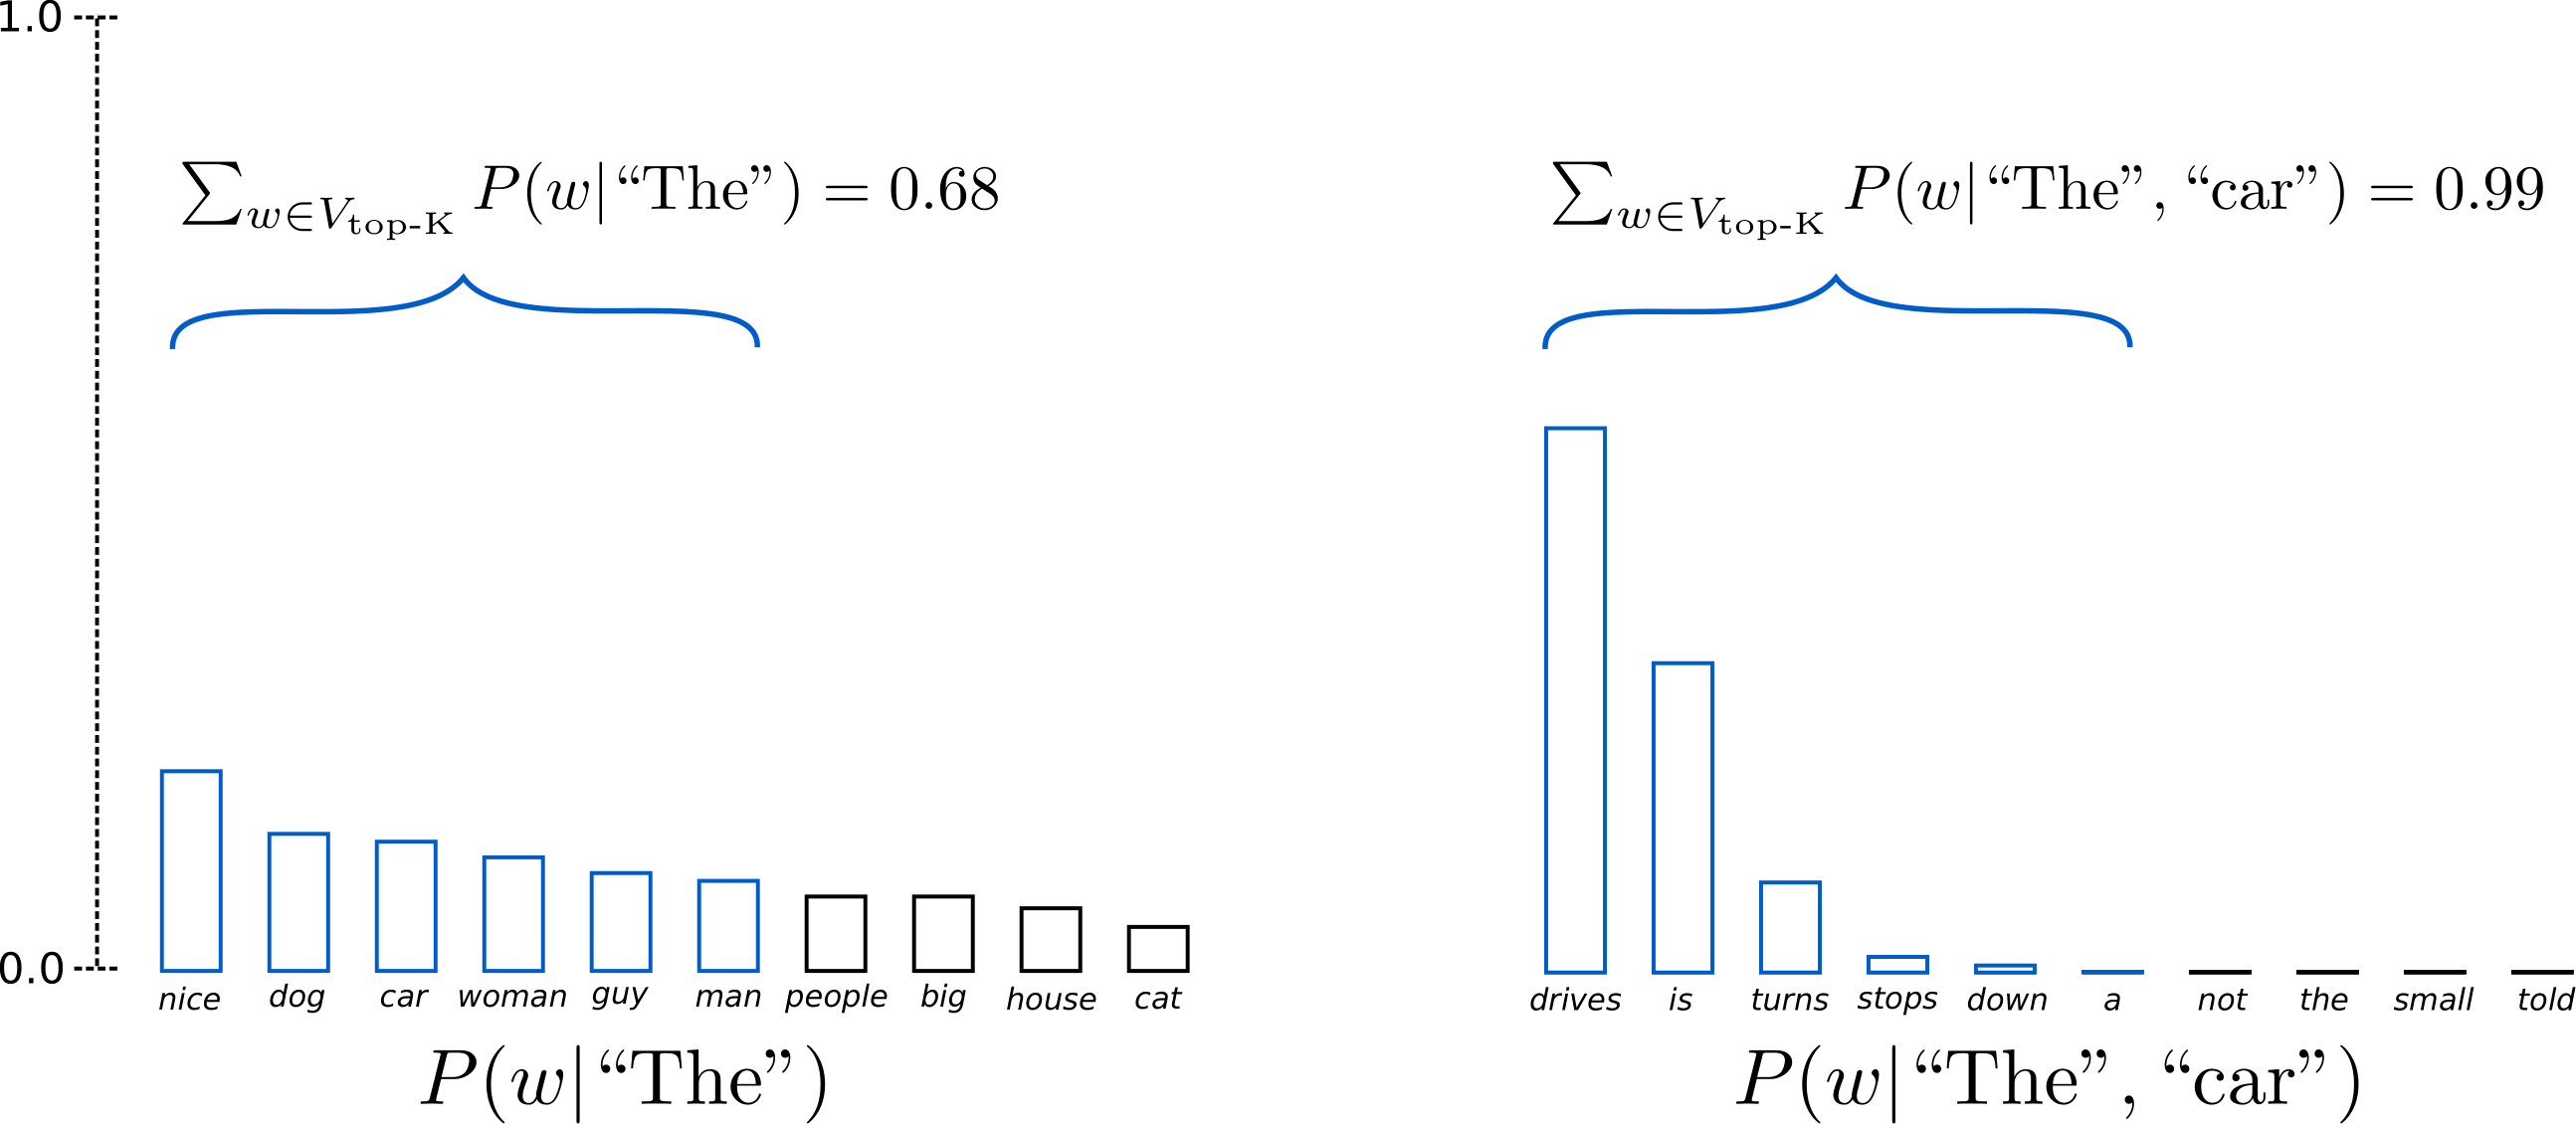 </td>
</tr></table>

[Интересный пост про генерацию с некоторым контролем](https://lilianweng.github.io/posts/2021-01-02-controllable-text-generation/)

## `5.2 Небольшой пример работы с предобученными моделями из huggingface`

[И упрощённый интерфейс генерации, тем кто хочет с ней поиграться](https://huggingface.co/blog/how-to-generate)

In [56]:
! pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [57]:
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

2023-03-30 07:01:37.384701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 07:01:37.934101: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/wsl/lib:
2023-03-30 07:01:37.935821: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/wsl/lib:
2023-03-30 07:01:37.935830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [58]:
input_ids = tokenizer.encode('She likes using language models to', return_tensors='np')
logits = model(input_ids)['logits'].numpy()
print('Размер logits — выхода сети', logits.shape)
index = logits[0, -1].argmax()
tokenizer.decode([index])

Размер logits — выхода сети (1, 6, 50257)


' describe'

### `Жадная генерация текста`

In [59]:
def greedy(words, k):
    for _ in range(k):
        # Получаем токены для каждого члена предложения
        tokens = tokenizer.encode(words, return_tensors='np')
        
        # Делаем предсказание для всего предложения и запоминаем последнее состояние
        logits = model(tokens)['logits'].numpy()[0, -1]
        
        # Делаем жадный поиск - просто argmax
        token_new = logits.argmax()
        
        # Обновляем предложение
        words = words + tokenizer.decode([token_new])
    print('Итоговое предложение')

    print('—' * 64)
    print(words)
    print('—' * 64)

**В чём существенный недостаток конркетно данной реализации?**

**Подсказка: основное преимущество RNN над другими моделями.**

In [60]:
words = 'She likes using language models to'
greedy(words, 3)

Итоговое предложение
————————————————————————————————————————————————————————————————
She likes using language models to describe the world
————————————————————————————————————————————————————————————————


In [61]:
words = 'Always pick the next token with the highest probability'
greedy(words, 7)

Итоговое предложение
————————————————————————————————————————————————————————————————
Always pick the next token with the highest probability of success.


The
————————————————————————————————————————————————————————————————


In [62]:
words = 'When generating samples from LM by iteratively sampling the next token'
greedy(words, 11)

Итоговое предложение
————————————————————————————————————————————————————————————————
When generating samples from LM by iteratively sampling the next token, we can use the following code to generate a new
————————————————————————————————————————————————————————————————


In [63]:
words = 'Did you put your name in the'
greedy(words, 17)

# Проблема зацикливания ( если долгая память постепенно забывается )

Итоговое предложение
————————————————————————————————————————————————————————————————
Did you put your name in the title of the book?


I did. I did. I did.
————————————————————————————————————————————————————————————————


In [64]:
words = 'Kazan is most likely the'
greedy(words, 7)

# Плохое качество в связи с OOB

Итоговое предложение
————————————————————————————————————————————————————————————————
Kazan is most likely the most likely candidate to be the next
————————————————————————————————————————————————————————————————


In [65]:
words = 'The process of creating a zip bomb includes 3 steps :'
greedy(words, 107)

Итоговое предложение
————————————————————————————————————————————————————————————————
The process of creating a zip bomb includes 3 steps :


1. Create a zip file with the following contents :


1.zip


2. Copy the zip file to your computer.


3. Open the zip file and copy the following contents :


1.zip


2. Copy the zip file to your computer.


3. Open the zip file and copy the following contents :


1.zip


2. Copy the zip file to your computer.


3. Open the zip file and copy the following
————————————————————————————————————————————————————————————————


### `Top-k `

In [66]:
tokens = tokenizer.encode('She likes using language models to', return_tensors='np')
logits = model(tokens)['logits'].numpy()[0, -1]
index = np.argsort(-logits)[:5]
print('Наиболее вероятные индексы:', index)
print('Наиболее вероятные слова в продолжении:', tokenizer.decode(index))

Наиболее вероятные индексы: [6901 4727 1037  905  787]
Наиболее вероятные слова в продолжении:  describe explain help show make


In [67]:
import scipy
def top_n(words, k, n):
    """
    n — параметр top-n
    
    k — количество слов
    """
    for _ in range(k):
        
        # Получаем токены для каждого члена предложения
        tokens = tokenizer.encode(words, return_tensors='np')
        
        # Делаем предсказание для всего предложения и запоминаем последнее состояние
        logits = model(tokens)['logits'].numpy()[0, -1]
        
        # Получаем top-n слов
        index = np.argsort(-logits)[:n]
        
        # Семплируем из топ-k индексов 
        probs = scipy.special.softmax(logits[index])
        choice = np.random.choice(index, 1, p=probs)
        
        # Добавляем слово
        words = words + tokenizer.decode(choice)
    
    print('Итоговое предложение')
    print('-' * 64)
    print(words)
    print('-' * 64)

In [68]:
words = 'She likes using language models to'
top_n(words, 3, 3)
top_n(words, 3, 7)

Итоговое предложение
----------------------------------------------------------------
She likes using language models to explain what's
----------------------------------------------------------------
Итоговое предложение
----------------------------------------------------------------
She likes using language models to make sense of
----------------------------------------------------------------


In [69]:
words = 'Always pick the next token with the highest probability'
top_n(words, 7, 3)
top_n(words, 7, 7)

Итоговое предложение
----------------------------------------------------------------
Always pick the next token with the highest probability of being a valid token.

----------------------------------------------------------------
Итоговое предложение
----------------------------------------------------------------
Always pick the next token with the highest probability. This is how it works for
----------------------------------------------------------------


In [70]:
words = 'When generating samples from LM by iteratively sampling the next token'
top_n(words, 11, 3)
top_n(words, 11, 7)

Итоговое предложение
----------------------------------------------------------------
When generating samples from LM by iteratively sampling the next token (or the next token in the list), the following
----------------------------------------------------------------
Итоговое предложение
----------------------------------------------------------------
When generating samples from LM by iteratively sampling the next token, a single token can represent a whole number of tokens
----------------------------------------------------------------


In [71]:
words = 'Did you put your name in the'
top_n(words, 17, 3)
top_n(words, 17, 7)

# Стоит отметить конструкцию

# know what it is you're talking about

Итоговое предложение
----------------------------------------------------------------
Did you put your name in the list of things you'd like to do in your career, and if so, what
----------------------------------------------------------------
Итоговое предложение
----------------------------------------------------------------
Did you put your name in the credits?


Yes. I'm from the U.S. and my name
----------------------------------------------------------------


In [72]:
words = 'Kazan is most likely the'
top_n(words, 7, 3)
top_n(words, 7, 7)

Итоговое предложение
----------------------------------------------------------------
Kazan is most likely the first to be arrested for his alleged
----------------------------------------------------------------
Итоговое предложение
----------------------------------------------------------------
Kazan is most likely the first to see this in action,
----------------------------------------------------------------


In [73]:
words = 'The process of creating a zip bomb includes 3 steps :'
top_n(words, 107, 3)
top_n(words, 107, 7)

# Модель с малым k тоже может зациклиться (логично, при k = 1 это жадный поиск)

Итоговое предложение
----------------------------------------------------------------
The process of creating a zip bomb includes 3 steps :


Step 1: Create the Zip Bomb


Step 2: Create the ZIP


Step 3: Create the ZIP


Step 4: Create the ZIP


Step 5: Create the ZIP


Step 6: Create the ZIP


Step 7: Create the ZIP


Step 8: Create the ZIP


Step 9: Create the ZIP


Step 10: Make a new zip and place the ZIP in the zip box


Step 11: Create the zip


Step 12: Create
----------------------------------------------------------------
Итоговое предложение
----------------------------------------------------------------
The process of creating a zip bomb includes 3 steps : 1. Create a zip file. 2. Create your own custom zip file. 3. Create a zip file with all of the following features (you may need to modify these features in order to use a new zip file): 1. A zip file to store all of your data 1. A custom folder that is not included with this zip file (e.g., your home folder) 2. A zip tha

## `5.3 Метрики качества языковых моделей.`

Допустим, что ваша модель занимается переводом с английского на русский. 
Она сделала предсказание 'Я люблю ходить в кино в пятницу'.

Два квалифицированных переводчика сделали свои переводы: 'Я предпочитаю ходить в кино по пятницам' и 'Я люблю посещать кинотеатры в пятницу'

Построим метрику качества вашего предсказания $S$ относительно существующей разметки $A_1, A_2$.

Традиционно их обозначают C - candidate и R - reference.

### [BLEU](https://aclanthology.org/P02-1040.pdf)

In [74]:
S = 'Я люблю ходить в кино в пятницу'.split(' ')
A_1 = 'Я предпочитаю ходить в кино по пятницам'.split(' ')
A_2 = 'Я люблю посещать кинотеатры в пятницу'.split(' ')
list_A = [A_1, A_2]
S, A_1, A_2

(['Я', 'люблю', 'ходить', 'в', 'кино', 'в', 'пятницу'],
 ['Я', 'предпочитаю', 'ходить', 'в', 'кино', 'по', 'пятницам'],
 ['Я', 'люблю', 'посещать', 'кинотеатры', 'в', 'пятницу'])

#### Пересечение предсказаний.

Рассмотрим предложения как множества. За качество возьмём долю предсказанных слов входящих в хотя бы один ответ.

$$ \cfrac{|C \cap (R_1 \cup R_2)|}{|C|} = \text{В нашем случае} = \frac{7}{7}$$

* Очевидный недостаток - для C = 'в в в в в в в в' мера тоже равна 1.



In [75]:
def simple_BLEU(S, list_A):
    un = set([])
    for list_ in list_A:
        un = un | set(list_)

    print(len([s for s in S if s in un]), '/', len(S))
    return len([s for s in S if s in un]) / len(S)

simple_BLEU(S, list_A), simple_BLEU(['в'] * 7, list_A)

7 / 7
7 / 7


(1.0, 1.0)

#### Пересечение множеств предсказаний.

Рассмотрим предложения как **мультимножества**. За качество возьмём долю предсказанных слов входящих в хотя бы один ответ с учётом кратности. Причём в качестве пересечения над множествами возьмём максимум.

$$ \cfrac{|C \cap^- (R_1 \cup+ R_2)|}{|C|} = \text{В нашем случае} = \frac{6}{7}$$

* для C = 'в в в в в в в в' мера  равна $\cfrac{1}{7}$.

In [76]:
# Создание мультимножеств
multi_un = [Counter(A) for A in list_A]
multi_un

[Counter({'Я': 1,
          'предпочитаю': 1,
          'ходить': 1,
          'в': 1,
          'кино': 1,
          'по': 1,
          'пятницам': 1}),
 Counter({'Я': 1,
          'люблю': 1,
          'посещать': 1,
          'кинотеатры': 1,
          'в': 1,
          'пятницу': 1})]

In [77]:
un = multi_un[0]
for multi_set in multi_un[1:]:
    for elem in multi_set.keys():
        if elem in un.keys():
            un[elem] = max(un[elem], multi_set[elem])
        else:
            un[elem] = multi_set[elem]
un

Counter({'Я': 1,
         'предпочитаю': 1,
         'ходить': 1,
         'в': 1,
         'кино': 1,
         'по': 1,
         'пятницам': 1,
         'люблю': 1,
         'посещать': 1,
         'кинотеатры': 1,
         'пятницу': 1})

In [78]:
# Вычитание из S мультимножества
multi_intersect = 0
for s in S:
    if s in un:
        if s in un.keys():
            multi_intersect += 1
            un[s] -= 1
            if un[s] == 0:
                del un[s]
        else:
            print(f'Не нашлось слова || {s} ||')
            None
print(multi_intersect / len(S))
un

0.8571428571428571


Counter({'предпочитаю': 1,
         'по': 1,
         'пятницам': 1,
         'посещать': 1,
         'кинотеатры': 1})

In [79]:
def multi_BLEU(S, list_A):
    # Построение мультимножеств
    multi_un = [Counter(A) for A in list_A]
    
    # Взятие максимального объединения
    un = multi_un[0]
    for multi_set in multi_un[1:]:
        for elem in multi_set.keys():
            if elem in un.keys():
                un[elem] = max(un[elem], multi_set[elem])
            else:
                un[elem] = multi_set[elem]
                
    # Подсчёт уникальных вхождений
    multi_intersect = 0
    for s in S:
        if s in un:
            multi_intersect += 1
            un[s] -= 1
            if un[s] == 0:
                del un[s]
        else:
            print(f"Не нашлось слова '{s}'")
            None
    
    print(multi_intersect, '/', len(S))
    return multi_intersect / len(S)

print('Для предложения №1')
x = multi_BLEU(S, list_A)
print(f'Мера равна {x}\n\n')
print('Для предложения №2')
y = multi_BLEU(['в']*7, list_A)
print(f'Мера равна {y}')

Для предложения №1
Не нашлось слова 'в'
6 / 7
Мера равна 0.8571428571428571


Для предложения №2
Не нашлось слова 'в'
Не нашлось слова 'в'
Не нашлось слова 'в'
Не нашлось слова 'в'
Не нашлось слова 'в'
Не нашлось слова 'в'
1 / 7
Мера равна 0.14285714285714285


In [80]:
# Примеры менее типичных и неверно построенных предложений

S_2 = 'посещать Я кино по пятницам люблю'.split(' ')
S_3 = 'Я в ходить пятницу по кино люблю'.split(' ')

print('Для предложения №2')
x = multi_BLEU(S_2, list_A)
print(f'Мера равна {x}\n\n')
print('Для предложения №3')
y = multi_BLEU(S_3, list_A)
print(f'Мера равна {y}')

Для предложения №2
6 / 6
Мера равна 1.0


Для предложения №3
7 / 7
Мера равна 1.0


#### Пересечение предсказаний по N-граммам.

Составим мультимножество Биграмм по C и R попробуем использовать предыдущую метрику для них, а не мультимножеств слов. 


In [81]:
def get_bi(S):
    # Возвращает все биграммы
    # Tuple для хэширования
    return [(S[i], S[i+1]) for i in range(len(S)-1)]

S_bi= get_bi(S)
S_bi

[('Я', 'люблю'),
 ('люблю', 'ходить'),
 ('ходить', 'в'),
 ('в', 'кино'),
 ('кино', 'в'),
 ('в', 'пятницу')]

In [82]:
def bi_BLEU(S, list_A):
    S_bi = get_bi(S)
    list_bi = [get_bi(A) for A in list_A]
    
    return multi_BLEU(S_bi, list_bi)

In [83]:
bi_BLEU(S, list_A)

Не нашлось слова '('люблю', 'ходить')'
Не нашлось слова '('кино', 'в')'
4 / 6


0.6666666666666666

In [84]:
bi_BLEU(S_2, list_A)

Не нашлось слова '('посещать', 'Я')'
Не нашлось слова '('Я', 'кино')'
Не нашлось слова '('пятницам', 'люблю')'
2 / 5


0.4

In [85]:
bi_BLEU(S_3, list_A)

Не нашлось слова '('Я', 'в')'
Не нашлось слова '('в', 'ходить')'
Не нашлось слова '('ходить', 'пятницу')'
Не нашлось слова '('пятницу', 'по')'
Не нашлось слова '('по', 'кино')'
Не нашлось слова '('кино', 'люблю')'
0 / 6


0.0

#### Штраф за краткость
Вспомним, что мы ищем. И представим, что S = {a}

$$ \cfrac{|S \cap^- (A_1 \cup+ A_2)|}{|S|} = \text{В нашем случае} = \frac{1}{1}$$


In [86]:
S_short = 'в кино'.split(' ')
bi_BLEU(S_short, list_A)

1 / 1


1.0

Необходимо добавить штраф за слишком короткий ответ:

Пусть c — длина перевода-кандидата, а r — эффективная длина корпуса перевода.

Тогда штраф по длине вводится как 

$$
\text{BP} =
\begin{cases}
1&\text{, если }  c > r\\
(1−r/c)&\text{, если }  c \le r
\end{cases}
$$

#### Итоговая метрика вычисляется по следующей формуле:

$$
 \text{BLEU}(C) = \text{BP} \exp{\sum_{n=1}^N w_n p_n}
$$

Где N — верхняя граница параметров N-грамм $w_n$ — веса при оценках по N-граммам.

p_n — обобщение той метрики, что мы только что считали для биграмм, но на случай n-грамм.

$$
p_n(C,R) = \cfrac{1}{|C|} \sum \limits_{s\in G_n(C)}\min \left \{ \text{count}(s,C), \text{count}(s,R)\right\}
$$

$G_n(C)$ — множество n-gram, входящих в C.

**В оригинальной статье $p_n$ вычисляется по всему корпусу предсказаний** 

### [ROUGE](https://aclanthology.org/W04-1013.pdf)

Пусть снова C — candidate (т.е. наш ответ), R — reference (то есть истинная разметка).

Существует несколько типов ROUGE метрик, для каждой можно посчитать precision и recall:

#### ROUGE-N

Сначала считаем количество N-грамм из C, входящих в R. С учётом кратности.

$$
\text{power} = \sum \limits_{s\in G_n(C)}\text{count}(s,R)
$$

Далее

$$
\text{ROUGE-N-Precision} = \cfrac{power}{|G_n(C)|}\\
\text{ROUGE-N-Recall} = \cfrac{power}{|G_n(R)|}
$$

#### ROUGE-L

Пусть LCS — наибольшая общая подпоследовательность. 

$$
\text{ROUGE-L-Precision} = \cfrac{|LCS|}{|C|}\\
\text{ROUGE-L-Recall} = \cfrac{|LCS|}{|R|}
$$

**Напоминание** А можно сразу считать и F-меру.

$$
 \text{F-measure} = 2 \cfrac{\text{Precision}\cdot\text{Recall}}{\text{Precision}+\text{Recall}}
$$

Существуют другие модификации.

##  `5.4 Модели класса 'unsupervised pretraining'. Transfer learning.`

1. Обучаем LM на больших корпусах текста.

2. Дообучаем модель на данных из конкретной задачи.

3. Добавляем слой, отвечающий за решение задачи. (В случае классификации — один классификатор)


Примеры таких моделей:

[ULM](https://arxiv.org/abs/1801.06146)

<div>
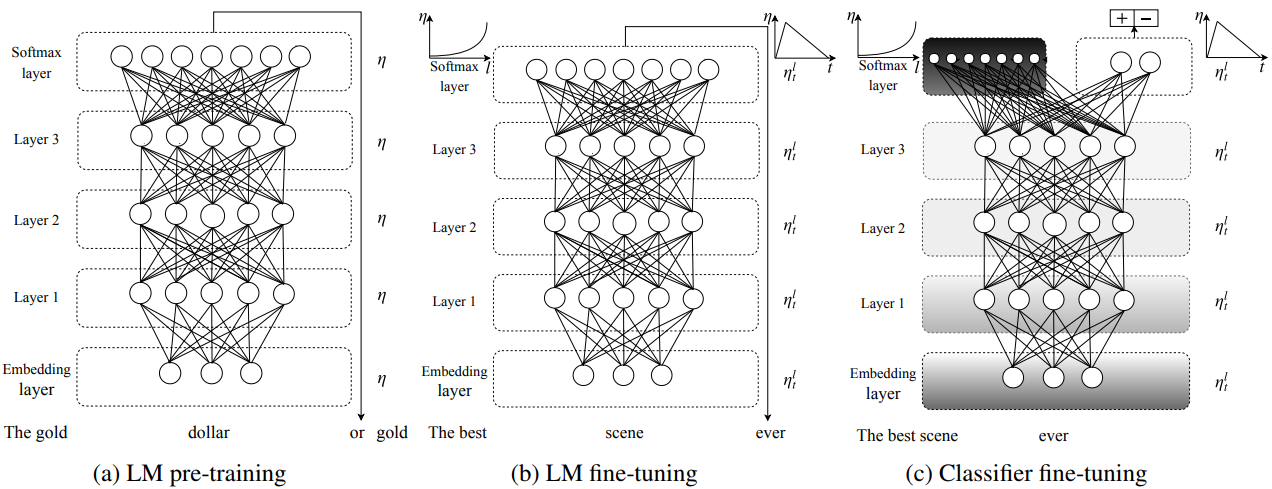
</div>

[ELMo](https://arxiv.org/pdf/1802.05365.pdf) — Embeddings from Language Models.

Дословно, представления для слов из языковых моделей.


<figure class="image">
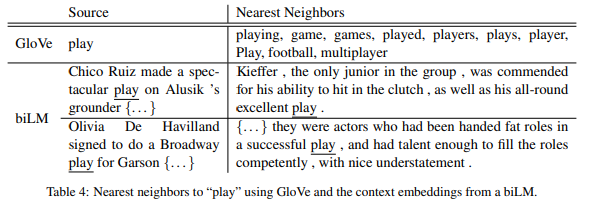 <figcaption>Сравнение стандартного подхода к эмбеддингам и ELMo</figcaption> 
</figure>


#### `Модель FastText. Решение проблемы Out-of-vocabulary`:

$f_\theta(w)$ строит векторное представление для $w$ посимвольно

Для обучения используется MSE для предобученных векторов и выходов $f_\theta(w)$:

$$
\mathcal{L}=\sum_{w \in W} ||f_\theta(w) − v_w||^2 \to \min_θ
$$

<div>
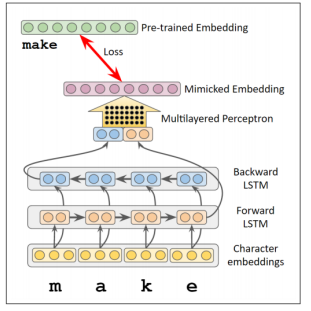
</div>

К ним также можно отнести GPT, BERT. (см. следующие семинар) 